<a href="https://colab.research.google.com/github/pmontman/covid19-datapooling/blob/main/Data_pooling_pandemic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# On data pooling for pandemic forecasting


> Pablo Montero Manso (pablo.monteromanso@sydney.edu.au)


> Firs version: May 2021
**WORKING PAPER**
---

**PRESS HERE TO OPEN NOTEBOOK IN GOOGLE COLAB**

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pmontman/covid19-datapooling/blob/main/Data_pooling_pandemic.ipynb)

---

* We show that models based in growth curves, such as the Gompertz, can be equivalently parameterized as autoregressive functions.
* We show that there are 'special' autoregressive functions that are
shared among all possible Gompertz curves: different Gompertz curves become the same process when parameterized as these special autoegressive functions.
* These 'special' autoregressive functions enable a powerful data pooling mechanism, because the data from seemingly different pandemic time series can be pooled together to estimate these functions without sacrificing flexibility. This contrast with both the straightforward way of fitting a curve to each time series in isolation and other data-pooling methods that assume some form of similarity among time series, sacrificing flexibility.
* The result is a very accurate data-driven method to predict the pandemic evolutions, which can also be used in conjunction with epidemiological models to improve the estimation of their parameters.

---

**Instructions for use the notebook:**
This is a notebook with some interactive plots.
Please start by running all code sections, go to `Runtime -> Run All`.
Sections of the notebook containing 'Interactive plot' in their title should have some form of interaction, some sliders that can be adjsuted. If not working (e.g. sliders not showing), try clicking on the 'play' button that appears when hovering the mouse over the section title, or just
`Runtime -> Run All` again.

----



# 1) Introduction

Our starting assumption is that real pandemics can be accurately *described* by certain families of curves, such as SIR models or Gompertz curves **(Section 2.1)**.
The evolution of a pandemic can even be *predicted* with these models by finding a curve within the family that fits the observed data well and then extrapolating using that curve. However, this method of prediction has some real-world limitations, it is difficult to find the right curves during the earlier stages of a pandemic, because of data quality/quantity issues and deviations from the ideal model. This is a non-obvious phenomena, even when these models describe the real pandemic well, meaning that there is a curve that approximates the data well (once it has been fully observed), predicting with these models (finding the right curve beforehand) is hard **(Section 5.1)**.

These families of idealized curves can be alternatively parameterized as autoregressive processes **(Section 2.2)**. Curve-based models are functions of time, autoregressive are functions of previous time-steps, but both can produce the same curves. We reason that **if** the evolution of a pandemic can be accurately modeled and predicted by curve-based models, then it can also be modeled and predicted by autoregressive processes.

The differences between curve-based and autoregressive appear in practice, when working with real data. There are few data points, there is 'noise' in the data, there are systematic perturbations or deviations from our idealized curves such as weekend effects or more fundamental ones such as the caused from interventions, several overlapping 'waves' and so on.
The nature of the pandemic growths causes even very small mistakes in the estimation of the curve model to accumulate over time and result in very inaccurate predictions **(Section 5)**. Autoregressive models are very flexible and can adapt to some of these systematic deviations in a purely data-driven way **(Section 4)**, while we would need to come up with new curve-based models. Nevertheless, both curve-based and autoregressive models have limitations, and it can be argued that basic auto-regressive models overall produce poorer predictions than curve-based in real scenarios **(Section 5.2)**.

 Our contribution lies in showing that there is yet another 'alternative parameterization' of the family of curves as autoregressive process that is 'universal': the same for all possible curves in the family, a function with the same coefficients that can be used to accurately predict all curves **(Section 3)**. This means that while with curve-based or individual autoregressive models we have to find the right coefficients that produce a curve for each pandemic time series (one for Italy, another for Spain, another for the US...) this alternative parameterization is the same for all time series.

This 'universal' function is 'slightly' more complex than what is strictly necessary to model individual curves with autoregressions, but in exchange, it can model all possible curves. The benefit in practice is that we can now try to find this 'universal' process from the data, using *all available time series* instead of using one time series at a time, a mechanism known as data-pooling. This reduces the uncertainty in the estimation of the coefficients. Not only that, this alternative parameterization is rich enough to automatically capture some of the systematic perturbations or deviations, leading to better forecasts. Data-pooling can also be used with curve-based models, but it is more limited. In simple words, two real time series do not follow the same curve in general, so choosing which time series are pooled together becomes a 'highly heuristic' exercise. 

Part of the purpose of this document is to *draw attention to this idea and improve upon it, not to pose it as a definitive answer or superior solution*.
We discuss limitations and paths to overcome them in **(Section 6)**. 

This document is structured as first the theoretical derivations, then the experiments to asses the relevance of the derivations in practice.

In [1]:
from __future__ import print_function

!! We need to downgrade rpy!!!

In [2]:
!pip install rpy2==3.5.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
#@title
%load_ext rpy2.ipython

# 2) The pandemic curves

> *Quote summarizing the section*

We have heard that pandemics or population growth can be described by an 'S'
shape curve, also called logistic or sigmoid cuves. These curves describe the cumulative counts of the measured variable given the time, for example the number of cases tested positived, deaths, hospitalizations.
In the next figure we can see the real time series for cumulative cases for different countries, for the first COVID19 wave (year 2020). We can see that all follow a 'S' type of shape, though there are great differences between countries. There are also striking similarities, as in the case of Spain and Italy, we will come back to that later.


Attaching package: ‘lubridate’



    date, intersect, setdiff, union




Rows: 100391 Columns: 60
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr   (4): iso_code, continent, location, tests_units
dbl  (55): total_cases, new_cases, new_cases_smoothed, total_deaths, new_dea...
date  (1): date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


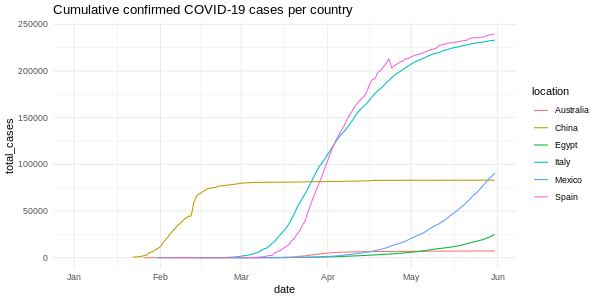

In [4]:
#@title R code: load data and plot covid cases
%%R -w 600 -h 300

rm(list=ls())
options(tidyverse.quiet = TRUE)
library(tidyverse)
library(lubridate)
library(ggplot2)
options(readr.num_columns = 0)
{
    sink(type="message")
    a <- capture.output(install.packages("gridExtra", verbose=FALSE, quiet=TRUE))
    sink(type="message")
}
if (0) {install.packages("plotly", verbose=FALSE, quiet=TRUE)}
#covid_global = readr::read_csv("https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/owid-covid-data.csv",
#                               , guess_max = 50000)
covid_global = readr::read_csv("https://raw.githubusercontent.com/owid/covid-19-data/5b39403f6c59d398b2521c8b04f4188bae29588e/public/data/owid-covid-data.csv",
                               , guess_max = 50000)
#plot total cases
covid_global %>%
 filter(location %in% c("China", "Italy", "Spain", "Egypt", "Mexico", "Australia")) %>%
 filter(date < "2020-06-01") %>%
 ggplot(aes(x=date, y=total_cases, color=location)) +
 geom_line() + theme_minimal() +
 ggtitle("Cumulative confirmed COVID-19 cases per country")

The cumulative count of patients that have been admitted to hospital in each country follows a similar type of 'S' pattern.

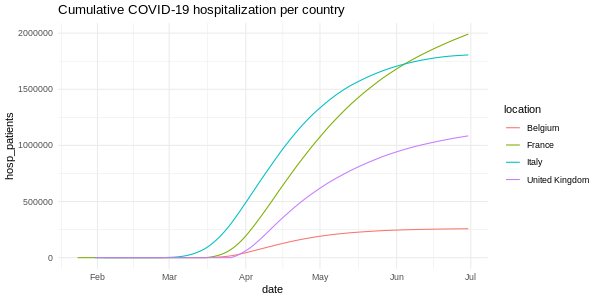

In [5]:
#@title R code: plot hospitalizations
%%R -w 600 -h 300


top_hosp = covid_global %>% select(location, date, hosp_patients) %>%
filter(date < "2020-06-01") %>%
filter(!is.na(hosp_patients)) %>%
group_by(location) %>% tally() %>% top_n(20, n)

covid_global %>%
 #filter(location %in% top_hosp$location) %>%
 filter(location %in% c("France", "Italy", "United Kingdom", "Belgium")) %>%
 filter(date < "2020-07-01") %>%
 group_by(location) %>%
 mutate(hosp_patients = ifelse(is.na(hosp_patients), 0, hosp_patients)) %>%
 mutate(hosp_patients = cumsum(hosp_patients)) %>%
 ggplot(aes(x=date, y=hosp_patients, color=location)) +
 geom_line() + theme_minimal() +
 ggtitle("Cumulative COVID-19 hospitalization per country")

## 2.1) Curve-based models

These curves can be described mathematically in different ways. One of those ways is the so-called Gompertz family of curves. We choose the Gompertz because it has been used to describe and *successfully forecast* COVID-19 [CITATIONS NEEDED], but other families could do, so for the sake of exposition we ask the reader to just temporally *assume* that Gompertz curves are good enough to be used for pandemics, scientifically sound. Gompertz curves are nice for expository purposes, they have a clean linear interpretation, but it is important to keep in mind that **the results that we will show are general enough to be valid for other models such as the compartimental SIR**. 

The Gompertz curve can be parameterized as a function of time with three parameters $A$, $B$ and $C$ controlling different aspects of the curve.
Briefly $A$ controls the asymptote (the value at the top), $B$ the displacement in time (when the growth starts) and $C$ controls the rate of growth ([see wikipedia](https://en.wikipedia.org/wiki/Gompertz_function)).
$$f(t) = Ae^{-Be^{-Ct}}$$

In the following cell we declare the `gompertz` function and plot an example of
gompertz with coefficients $A=3$, $B=1.5$, $C=2.2$. It clearly resembles the shape of some of the curves for the countries above. In this example both the values for time and the parameters have been arbitrarily chosen, but the idea is that by tweaking the values for $A$, $B$ and $C$ we will be able to approximate *any* of the real curves of cases and hospitalizations shown before. 

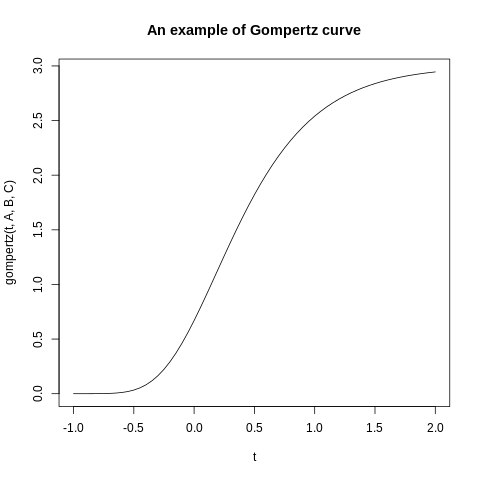

In [6]:
#@title R code fore simulating Gompertz curves
%%R
gompertz = function(t, A, B, C) {
  A * exp(-B*exp(-C*t))
  #A * exp(-C*t)
}
{
 A = 3
 B = 1.5
 C = 2.2
 t = seq(-1, 2, 0.05)
 example_gompz = gompertz(t, A, B, C)
 plot(t, example_gompz, type="l", ylab="gompertz(t, A, B, C)", main="An example of Gompertz curve")
}

### Gompertz curves describe real time series and motivate the use of autoregressive models

For example, we can see in the next plot that there is a Gompertz curve that greatly resembles the real confirmed cases for Italy and Spain. The approximation for China is not as good, but if we could have gotten that approximation in January 2020 that would be very good indeed. This is non-trivial, the fact that we already have models that are able to describe the pandemics relatively well. The difficulty lies in finding the correct values for $A$, $B$, $C$ **ahead of time** when the pandemic is beginning and we have few observations, not when it has been fully observed. 

We will later show that the family of curves can also be represented with autoregressive models.

*This constitutes the starting point of our discussion: There is a family of curves that can describe the real pandemic evolution and we can reproduce these curves with autoregressive models, therefore autoregressive models can describe real pandemics.*

Then we will make the counter argument, that actually those curves cannot fully describe some of the real times series, either because of 'noise' or 'nuisance perturbations'(weekend effects) or fundamental deviations (multiple overlapping waves, interventions such as lockdowns). These deviations affect both curves and autoregressive models, and in some form explain why we cannot get perfect predictions in practice.

Then we will show a special autoregressive function with great potential for solving some  of the limitations of curve-based models (and non-special autoregressions).


*NOTE: A thing that is surprising to me is how the curve fits so well in the case of Italy when a severe lockdown was introduced mid March, testing procedures were changing during that period and so on, Is this expected?*

NULL


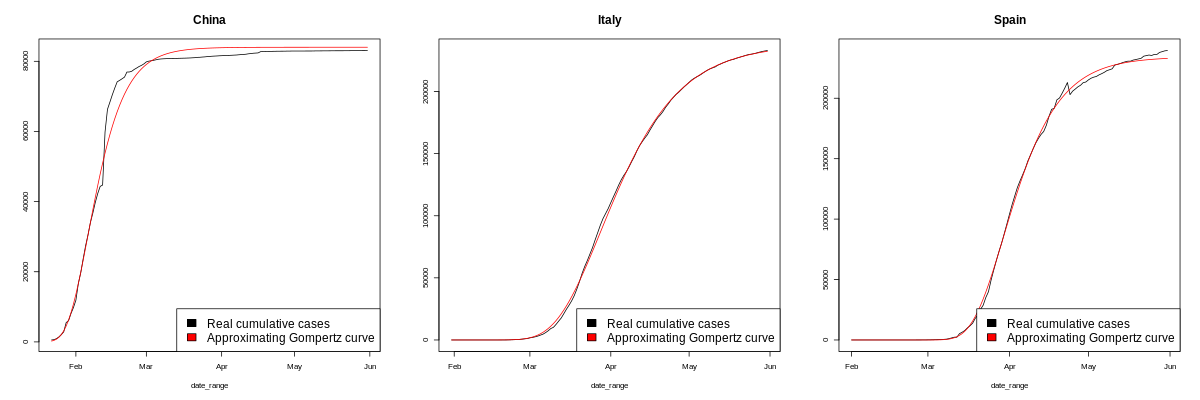

In [7]:
#@title R code for fitting Gomperzt and plotting the fits
%%R -w 1200 -h 400

#loss function for fitting a gompertz
err_fitgompz = function(w, x, t) {
  tbase = t[1:length(x)]
  pred = gompertz(tbase, w[1], w[2], w[3])
  sum(abs(x-pred)**2)
}

#grid search for the Gompertz
grid_optim = function(x , t, n.grid=93) {
  w_range = expand.grid(A=seq(0.1, 1.5, length.out=n.grid),
                        B=seq(0.5, 1.5, length.out=n.grid),
                         C=seq(2, 6, length.out=n.grid))
  errs = apply(w_range, 1, function (w) {
      err_fitgompz(w, x, t)
  })
  as.numeric(w_range[which.min(errs),])
}

#pre calculated curves, to save computing time
precalc_curves = tibble(location="China", A=0.336, B=0.003, C=7.704) %>%
 bind_rows(tibble(location="Italy", A=0.9521739 , B=0.8478261, C=3.5652174)) %>%
 bind_rows(tibble(location="Spain", A=0.9369565 , B=0.8695652, C=5.0869565))

#plotting the fitted curves
opar = par
par(mfrow=c(1,3))
for (i in 1:nrow(precalc_curves)) {
 country_cases = covid_global %>%
  filter(location == precalc_curves$location[i]) %>%
  filter(date < "2020-06-01") %>%
  select(date, total_cases)

 date_range = country_cases$date
 country_cases = country_cases$total_cases / 250000 #normalize for numerical reasons
 t_base = 1:length(country_cases) / length(country_cases)
 t_base = 2*(t_base - max(t_base)/2)
 #w_srch = grid_optim(country_cases, t_base) #search is precalc for speedup
 w_srch = as.numeric(precalc_curves[i,-1])
 plot(date_range, 250000*country_cases, type="l", ylab="", main=precalc_curves$location[i], cex.main=1.5)
 fitted_gompertz = gompertz(t_base, w_srch[1],
                           w_srch[2],
                           w_srch[3])
 lines(date_range, 250000*fitted_gompertz, col="red")
 legend("bottomright", fill=c("black", "red"),
                             legend= c("Real cumulative cases", "Approximating Gompertz curve"),
        cex=1.5)
}
par(opar)

## 2.2) Autoregressive models

In simple terms, when we have a process that evolves over time, we can describe it:
 *  As a function of time, as we have seen with the Gompertz. Given
 the value of time as input, we compute the value of the measured process at that point in time.
 * But we can also describe a process as a function of its own previous values, that is why it is called auto-regressive. Given some past values, compute the value of the process for the next time step.

In Statistics / Machine Learning we call the latter autoregressive models, and are 'related' to Dynamical Systems/Time Delay Embeddings that appear in many scientific disciplines.

A basic example of these two alternative parameterizations is 'compound interest' or 'exponential growth'.
We can decribe how a a monetary quantity $M_0$ at 10% interest rate evolves over time in two different ways, as a function of time, or as a function of the monetary value at previous time steps (autoregressive).
$$M(t) = M_0 1.1^t \leftrightarrow  M(t+1) = 1.1M(t)$$

### Autoregressive parameterization of Gompertz curves 

The Gompertz curve can be parameterized or represented as a simple autoregressive function.
The way to show this is to 'unroll' the equation of the Gompertz curve
a few time steps. Starting from the curve function:
$$f(t) = Ae^{-Be^{-Ct}}$$
we see how it looks like in the next time step:
$$f(t+1) = Ae^{-Be^{-C(t+1)}} = Ae^{-Be^{-Ct -C}} = Ae^{-Be^{-Ct}e^{-C}}$$

We can see that $f(t+1)$ contains the expression for $f(t)$, highlighted
in red below, we can rewrite it so we get how to compute $f(t+1)$ as a function
of $f(t)$, not as a function of time.

$$f(t+1) = \color{red}{Ae}^{\color{red}{-Be^{-Ct}}e^{-C}}$$
$$f(t+1) = A\left( \frac{f(t)}{A} \right)^{e^{-C}} $$

Importantly, the way to compute $f(t+1)$ *given* $f(t)$ does not depend on time $t$,
it is 'time invariant' (not a rigorous term), which simplifies things. $f(t)$ can be understood as the 'latest observed value', and so we get a formula for how to calculate the next value given the latest observed one. The example in the case of a pandemic, given the total cumulative cases on day $t$, $f(t)$, we can compute the total cumulative cases the next day $f(t+1)$. We could apply the formula more times recursively to compute the values for more days into the future.

At this point it is probably useful to take logarithms, to simplify a  bit:

$$log(f(t+1)) = e^{-C}log(\frac{f(t)}{A} ) + log(A)$$
$$log(f(t+1)) = e^{-C}log(f(t)) - e^{-C}log(A) + log(A)$$

In other words, if we rewrite the logarithm of the Gompertz curve as
 $l(t) = log(f(t))$, we get a linear process.

$$l(t+1) = \alpha l(t) + \beta$$
Where $\alpha=e^{-C}$ and $\beta =e^{-C}log(A) + log(A)$. 

We notice that the autoregressive form has one less
parameter than the Gompertz, at this point a very rough idea, but will come into play later. In sum, with this technique we get an autoregressive linear function that is **equivalent** to the Gompertz.
If you do not believe it, try it yourself!


To double check (numerically), in the next cell we will fit a linear autoregressive model to the logaritm of the simulated Gompertz curve in previous section. We can see that we get a 'perfect fit' (an average approximation squared error of $10^{-15}$). NOTE: What we get will depend on the time step size, we have chosen a time step of 1 in our derivations for simplicity, but we should could have chosen an arbitrary time step $f(t + \tau)$ instead of $f(t+1)$. In our numerical example we use a $\tau=0.05$. We get an $\alpha=0.896$ and $\beta=0.114$. 




In [8]:
#@title R code for fitting a linear AR model and showing perfect fit
%%R
modeldata = embed(log(example_gompz),2)
colnames(modeldata) <- c("next_tstep", "current_tsep")
modeldata <- as.data.frame(modeldata)
summary(lm(next_tstep ~ current_tsep, modeldata))


Call:
lm(formula = next_tstep ~ current_tsep, data = modeldata)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.803e-15 -2.286e-16  9.171e-17  2.062e-16  2.671e-15 

Coefficients:
              Estimate Std. Error   t value Pr(>|t|)    
(Intercept)  1.144e-01  7.918e-17 1.445e+15   <2e-16 ***
current_tsep 8.958e-01  2.293e-17 3.906e+16   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 5.835e-16 on 58 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.526e+33 on 1 and 58 DF,  p-value: < 2.2e-16



### Differences between curve-based and autoregressive models

We have shown an equivalence, so at a 'theoretical' level the Gompertz curve and this autoregressive model are the same. Why should we use one or the other? The difference will appear in practice, because there are deviations from the ideal curves. For example, in the case of COVID, What happens when there is noise in the data, systematic changes such as weekend effects, non-farmaceutical interventions such as lockdowns, vaccinations, multiple waves and so on?. So the question is whether they behave equivalently in practice, or when it is better to use one technique or the other and so on.


# 3) 'Universal' autoregressive functions: A theory of data pooling with autoregressive models

> *Quote summarizing the section*

**This section contains the main contribution** of the work.

Accurate forecasting is a hard problem, as we will see in Section 5 (though it's common sense). One common limitation is the lack of data quantity or data quality to fit models, even when we know we are using the right models. A way to minimize some of this issues is a technique known as 'data pooling'.


Data pooling roughly refers to the use of external information in order to improve our modeling of the problem at hand. It usually starts by assuming that we do not have enough data to fit a model for our problem, but we have data of 'similar' problems that we could use to augment our dataset. There is a tradeoff between the amount of data that we gain and the quality of this data.
This is a widely applied idea, it gets the name of pooled regression in econometrics, it is related to transfer/multitask learning in Machine Learning, Bayesian hierarchical models or this extra data constituting some form 'prior information'. Lately it has been termed 'global models' in time series forecasting.

 Take the example of COVID cases for Italy and Spain. We can argue that Italy and Spain are countries with similar characteristics, therefore we could try to fit a curve that fits both countries well (especially at the beginning of the pandemic when there is not much data). So the same curve must fit both datasets, the data is pooled together. The hope is that the amount of data that we gain to estimate this curve compenstates for the fact that the curve being estimated is not going to fit each time series perfectly well. We expect that overall we will get more accurate predictions. We can make the example more sophisticated by allowing a different curve for each country, but imposing that one of the coefficients is the same for both, e.g. the rate of growth ($C$ in the Gompertz curve) is the same for Italy and Spain. These forms of data pooling contrast with the straightforward idea of fitting one curve to the data of each country, and
there is a **clear tradeoff**, we have doubled the amount of data, but if our assumptions of similarity are wrong, then we could be making a big mistake. We can think that most forms of data pooling sacrifice generality when compared to the straightforward fitting (not pooling), because the more general statement is that each region follows a different curve. Moreover, the way we choose which series are pooled together is 'heuristic' or 'arbitrary' or ' an educated guess', especially at the early stages of a pandemic.

What we will show in this section can be considered 'data pooling' but of a very
different nature, to the extreme of claiming tha initially it should strike as something counterintuitive.  We will provide a rigorous, systematic and exact way of doing data pooling for Gompertz curves, without tradeoffs. We will show that there is a special autoregressive model class that is able to capure **all** available information (data from all different curves) while being able to exactly represent each individual curve.

We will present a result about a model class that deviates from other forms of data pooling in two very important ways:

1. No assumptions of similarity are required. Assuming Gompertz curves as the underlying process, there is no sacrifice in generality / tradeoff with data quantity. It is 'less of a heuristic' than other data-pooling methods.
2. We provide a specific mechanism on how to arrive to those 'special' models.
It is not a merely 'existence' result neither an assumption that a particular model class will work well. Other data pooling methods assume
that the time series follow a given common process without a proper explanation. Other data pooling methods are based on the assumption that same type of models that are used for the individual series can be used for the pooled data, therefore there is great benefit in pooling. Here we show that we must alter our models: the models used for individual data and pooled data must be different, and we show how they are different. 



## 3.1) A single AR function for all possible Gompertz curves

We start from the logarithm transform of the Gompertz curve for simplicity. 
Recall the autoregressive parameterization of the log of a Gompertz curve as:
$$l(t+1) = \alpha l(t) + \beta$$
Because we are working with what is essentially a linear model, the results developed here are much more generally applicable than pandemic or growth curves, but we will leave that for another time.

What we want to do is solve for $\alpha$ and $\beta$, and because these autoregressive coefficients do not depend on specific values of time (time invariant), what we get can be generally applied to other time steps. To solve for $\alpha$ and $\beta$ , two unknowns, we need more equations, which we can get by unrolling the original equation one more time.
$$l(t+2) = \alpha l(t+1) + \beta$$

We now have two equations and two unknowns, one solution for that, assuming no division by zero:
$$ \alpha = \frac{l(t+1) - l(t+2)} {l(t) - l(t+1)}$$
$$ \beta = \frac{l(t)l(t+2) - l(t+1)^2}{l(t) - l(t+1)}$$

We use the new representation $\alpha$ and $\beta$ to write the autoregressive model in yet another way. We will need to unroll the equation one more time and introduce the expressions for $\alpha$ and $\beta$ to see how it can be used to model the 'future' time steps.

$$ l(t+3) = \frac{l(t+1)l(t+2) - l(t+2)^2 + l(t)l(t+2) - l(t+1)^2} {l(t) - l(t+1)}$$

Since it does not matter which $t$ we choose, we can make this more understandable by rewriting this result in terms of how to compute the next time step:
$$ l(t+1) = \frac{l(t-1)l(t) - l(t)^2 + l(t-2)l(t) - l(t-1)^2} {l(t-2) - l(t-1)}$$

We get a 'less nice' formula that is equivalent to the original one, but interestingly, something has changed.
**There are no coefficients or 'free' parameters $\alpha, \beta$ specific to each curve, everything is a formula that depends only on past timesteps.
It is a 'universal' parameterization, we can describe *all* Gompertz curves with this particular autoregressive model**.

What does this have to do with data pooling? In practice when we use a curve based model, we have to estimate the three
coefficients $A, B, C$ for each series, because each series is 'different'. In the simple linear autoregressive of order 1, we need to estimate two coefficients $\alpha, \beta$ for each series. In this new autoregressive formulation, we get a 'universal' function that is the same for *all* Gompertz curves. 
Because this autoregressive formulation does not have coefficients, there is nothing to fit, so it might seem strange to talk about data and fitting. But we can think that there are coefficients of an 'unknown' underlying model.
 The point is that, *even if we did not know about this result*, we would have found it 'by chance' when trying to fit a 'polynomial model' to *the pool of all available time series*. In other words, if we try to fit a linear model with interactions of these terms
$$ l(t), l(t-1), l(t-2), l(t)^2, l(t-1)^2, l(t-2)^2, \frac{1}{l(t-2) - l(t-1)} $$
we would have found a perfect fit for the pooled data. Granted that the last term $\frac{1}{l(t-2) - l(t-1)}$ is not something that we would normally use, but the remaining terms make a simple polynomial of the last 3 time steps!

Restating it for clarity in the context of COVID. The curves of confirmed cases for China, Italy, Spain, the UK, France, Germany, the US, India, Australia, Egypt, etc. all follow the same 'special' autoregressive process. For that matter,  not only the cases, but also the time series of deaths, hospitalizations and ICU follow that same process (as long as we can describe them with Gompertz curves).

In practive, the time series will not follow the ideal Gompertz curves, but the
principle stays the same. There is an autoregressive model that is able to capture all individial time series, and we can find it from data. Using all
the data.

This is a powerful motivator to try to fit an *unrolled* (more lags) general data-driven model to *the pool of all the time series*, because it will be able to approximate all of them, no sacrifices in generality. <font color='red'> This means that while we might need to estimate a few more coefficients from the data, we can potentially have much, much more data to estimate them!.</font>

The main message is that
* There are 'universal' autoregressive parameterizations that are shared for all curves.
* We can find them by unrolling the process, considering more past time steps (or lags)
* Might be more 'complex' (e.g. nonlinearities)
* We have much more data to fit this 'universal' function than to fit the 'individual' curves.

We now have the main idea but not the full picture, because so far we have been working on the ideal scenario, where it does not really matter which approach we choose (Gompert, individual autoregressions, pooled). A clear example in the above 'polynomial' is that when two consecutive days report the same number of cases, the model will divide by zero. 
Later we will analyze some speficic cases and work on known deviations of the ideal curves and on real data.

**INTERPRETATION**

A poor attempt at interpretation follows. The idea that one function describes all different curves makes sense mathematically but it is a bit counterintuitive. We are showing that 'different' curves or even 'different' simple autoregressive processes are actually 'the same' under another paremeterization. This breaks our notion of 'similarity' on two fronts, the 'visual' which can be related to euclidean distance between curves, and even the one based on 'function similarity' when we use simple functions such as the Gompertz. To get a better intuition on this universal functions, we can think of this autoregressive parameterization as:
 * Each curve follows the same process evolving from different 'initial conditions'.
 * An 'algorithm' that calculates the coefficients of the original curve implicitly. Think of the closed form formula for least squares embedded in the polynomial.



## 3.2) Purely Linear approach to data pooling

We will show that we can get to this universality with just linear autoregressive, no need for polynomials.

Because of the properties of linear models and autoregression, there can be many more parameterizations that lead us to 'universal' models. One of them is purely linear autoregressive but with more lags (no polynomials). It will be quite powerful but not as universal, because it will not be able to capture all possible Gompertz curves, just a finite number that is depending on the amount of data that we have, the number of time-steps available. On the other hand, while strict linearity is not as powerful a representation, it is quite well behaved, interpretable, and a strong motivator towards this general approach. In other words, if we can show this effect with just linear models,
it is of great practical utility, and can help our understanding of the principle.

The way to show how just linear autoregressive models have a similar 'universal' effect (and the way I came to realize it) is by adding more lags or unrolling the linear model more than needed for a single curve. So instead of finding a nonlinear function, we can try to parameterize it as a linear function of even more 'past' observations. By considering more lags, we get more coefficients that we have to solve for ('unknowns').
Then we unroll the process to get more equations to solve for these extra unknowns, but the equations are linearly dependent, because the underlying process that we are unrolling is linear. Eventually we will get a 'low rank' system, meaning that there are infinitely many possibilities of a linear autoregressive process that have more lags than strictily required.

Now, lets say we have two different linear processes, we can parameterize each one using more lags so that they have infinitely many solutions. Then we know
that we can pick one such solution which is **the same for both processes**.
And that is the principle behind how to get to this 'universality' with purely linear autoregressive models. It is not as powerful because in general we would need to keep adding lags to accomodate more and more different individual processes.

 The following section gives an example of such derivations, but it is there for completeness, the underlying idea is what we have just mentioned, basic linear algebra combined with autoregression.


### Derivation of 'universal' linear processes by overparameterization
**WARNING: THIS SUBSECTION NEEDS REWORK!! IT IS NOT CORRECT**

We will show how two different but linear processes can be parameterized in such a way they get the same values for the parameters, so they become the same process. For example, we have two linear autoregressive processes,
 $$l(t+1) = \alpha l(t) + \beta$$
   $$g(t+1) = \gamma g(t) + \delta$$
What we do is reparameterize one process so it is a linear function of more past values, by solving for $\beta$
$$\beta = l(1+1) - \alpha l(t)$$
introducing it in the next time step:
$$l(t+2) = (\alpha+1) l(t+1) - \alpha l(t)$$

and we see that three contiguous time steps are linearly dependent. Moreover, in this parameterization there is only one free parameter $\alpha$ **?will this become important when stacking the two matrices?**.
We can see that there are many ways of expressing the process a linear function 
of past observations.
$$l(t+3) = (\alpha+1) l(t+2) - \alpha l(t+1)$$
$$l(t+3) = \alpha l(t+2) + l(t+1) - \alpha l(t)$$

We can think of *overparameterizing* by unrolling more, adding more lags than strictly necessary. In the general sense:
$$l(t+3) = \mathbf{a}l(t+2) + \mathbf{b}l(t+1) + \mathbf{c} l(t)$$

 The 'longer past' parameterization has infinitely many solutions that satisfy the original definition. For example, the trivial solution is to ignore the extra term:is $[\mathbf{a}=\alpha +1, \mathbf{b}=-\alpha,\mathbf{c}=0$]. Other
 solution shown above would be $[\mathbf{a}=\alpha, \mathbf{b} = 1, \mathbf{c}=-\alpha]$. Other solution is by substuting $l(t+2)$ by its expression as a function of past observations: $[\mathbf{a}=0, \mathbf{b}= (\alpha+1)^2 - \alpha, \mathbf{c}=(\alpha+1)\alpha ]$. We can already get infinitely many solutions by linear combinations of these three.

Then we can do the same for the process $g$ and get an equivalent results,
depending on $\gamma$, instead of $\alpha$. Finally, we would like to find 
the linear combination that makes the coefficients for $l$ and $g$ the same.

$$ \mathbf{a} := (\alpha+1)x - \alpha y =
 (\gamma +1)u + \gamma v $$
$$ \mathbf{b} := \alpha x +y + [(\alpha +1)^2 - \alpha] z =
\gamma u +v + [(\gamma +1)^2 - \gamma]w$$
$$ \mathbf{c} := -\alpha y + [(\alpha +1)\alpha] z =
-\gamma v + [(\gamma +1)\gamma] w$$
$$x+y+z=1$$
$$u + v + w = 1$$

Note, more variables than equations, maybe we can remove one variable?

The simplest explanation now follows from the linear algrebra as we can
create time delay embeddings of each of the two processes $l$ and $g$.
Each of these matrices will be rank two at most. If we stack two
rank two matrices we can get *at most* a matrix of rank 4, therefore, we can express two different processes as a linear autoregression of at most 4 parameters, with the same values for these parameters.


A system with two equations and two unkowns. Solving it would give a parameterization of the processes $l$ and $g$ that is the same for both. The limitation of this technique is that it is not that general, we would need to unroll one extra time and add one more coefficient to accomodate for three different processes. In general, we would need 'many lags' if we have 'many series'.However, we will see that in many practical situations we will not need that many lags, just a few lags will already get a very good approximation while hundreds would be required for the theoretical equivalence.


## Numerical experiments on data pooling

We will check the derivations in this Section 3 with numerical experiments, showing:
 * A linear autoregressive function 'perfectly' captures several different curves by adding lags. (Pooling all data from the curves together)
 * The universal autoregressive parameterization gets a perfect fit independently of the number of curves
 * How well a linear autoregressive can approximate many curves even when
 the number of lags is not enought to perfectly capture them.

The following code cells create the desired number of Gompertz curves (with random coefficients) and fit a linear model of the desired number of lags.
Then an interactive plot is produced where you will be able to select the number
of curves with `num_curves` and the number of lags for the linear model with `lag`, plotting curves and approximation error. We recommend to play around and also look for several effects:

 1. Start at 1 curve with a lag of order 1, see how it gets a perfect fit, an average absolute error of around $10^{-15}$.
 2. We move to 2 curves, then a model of lag 1 is not longer a perfect fit, we we an average error of 0.03.
 3. We move the lag to 2 (`num_curves=2`, `lag=2`) and the we get the perfect fit again. Note that the different of simply adding one lag to the model reduces the approximation error by a factor of $10^{12}$.
 4. At `lag=3` we still get a perfect fit. Beggining at lag 3, the plot shows the approximation error of the 'universal function', the polynomial coming from our analytical derivation in a red horizontal line. It should produce a perfect fit independent on the number of curves.
 5. The 'benevolent approximation' effect: Select a large number of curves and see how when we incrase the lags for the linear model we get a better approximation of the pooled data of all curves. But while the number of lags has to grow with the number of curves, in practice with a few lags we get very good approximations. Also see wo the fit of the 'universal' polynomial remains a perfect fit for all number of series. In text, the Data Points shows the 'degrees of freedom' in the fitting, it increases with the number of curves in the pool. In contrast, an individually fitted model of lag 1 would get constant 'degrees of freedom' (60 in the experiment).


In [9]:
#@title R code: create many curves and fit data-pooling AR models
%%R
#EXPERIMENT PARAMS, NUMBER OF LAGS and NUMBER OF SERIES
ideal_pooling_gompertz = function(nseries, lag) {
 set.seed(12345)
 Yg = NULL
 Xg = NULL
 all_gompz = NULL
 t = seq(-1, 2, 0.05)
 for (k in 1:nseries) {
   Ak = runif(1, 1, 4)
   Bk = runif(1, 0.1, 2)
   Ck = runif(1, 1, 3)  
   example_gompzk = gompertz(t, Ak, Bk, Ck) / Ak
   all_gompz[[k]] <- example_gompzk
   Xk = embed(log(example_gompzk), lag+1)
   Yk = Xk[,1, drop=FALSE]
   Xk = Xk[,-1, drop=FALSE]
   Xg = rbind(Xg, Xk)
   Yg = c(Yg, Yk)
 }

 err_purelin = 1:lag 
 for (sublag in 1:lag) {
     modelpurelin = lm(Yg~Xg[,1:sublag]-1)
     err_purelin[sublag] = mean(abs(modelpurelin$residuals))
 }

err_unianal = err_purelin[1]
if (lag >= 3) {
  Xequation = (Xg[,3]*Xg[,1] - Xg[,2]^2 + Xg[,2]*Xg[,1] - Xg[,1]^2) / 
               (Xg[,3] - Xg[,2])
  modeluniversalanalytical = lm(Yg ~Xequation )
  err_unianal = mean(abs(modeluniversalanalytical$residuals))
  Xauto = cbind(Xg[,1:3],
                1/(Xg[,3] - Xg[,2]),
                Xg[,1:2]^2)
  modeluniversaldatadriven = lm(Yg ~ (Xauto[,1] + Xauto[,2] + Xauto[,3] + Xauto[,4] + Xauto[,5] + Xauto[,6])^2 
            -1)
  err_unidriven = mean(abs(modeluniversaldatadriven$residuals))
 }


 #plot all curves
 colorpal = heat.colors(length(all_gompz))
 rgomp = range(unlist(all_gompz))
 png(paste('pool_gompz_',nseries,'_', lag, ".png", sep=""), width=800, height=400)
 layout(matrix(c(1, 2), 1, 2, byrow = TRUE),
   widths=c(1.75,1), heights=c(1,1))
 plot(t, all_gompz[[1]], type="l", ylim=rgomp, col=colorpal[1],
      xlab="",
      main = paste(nseries, "simulated Gompertz curves"),
      ylab="")
 if (k > 1) {
   for (k in 2:length(all_gompz)) {
     lines(t, all_gompz[[k]], type="l", col=colorpal[k]) 
   }
 }
 plot(1:lag, log10(err_purelin), type="o", ylim = range(c(log10(err_purelin), log10(err_unianal))),
      xlab ="Lag order of the linear model",
      ylab="log10(approximation error)",
      main="Approximation error of \n pure linear data pooling w.r.t. \n the lag order")
 if (lag >= 3 ) {
     abline(h=log10(err_unianal ), col="red")
     text( 0.5 + lag/2, log10(err_unianal ), "Error of the universal poly model", col="red")
 }
 dev.off() 

 cat(paste("Data Points:", length(Yg), "[num_curves*(points_per_curve - lag)]"))
 cat( paste("Approximation Error of a Purely Linear Model of lag=",
              lag, ":", err_purelin[lag]))
 cat(paste("Relative reducton in error compared to lag=1:", err_purelin[1]/err_purelin[lag]))

}

In [10]:
#@title Python code: Interactive plot for simulated data-pooling AR
from IPython.display import Image
import rpy2.robjects as robjects


rplot_pool = robjects.r['ideal_pooling_gompertz']


#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

@interact(num_curves= widgets.IntSlider(min=1, max=128, step=1, value=1,
                                        layout=Layout(width='50%', height='18px')),
          lag=widgets.IntSlider(min=1, max=25, step=1, value=1,
                                layout=Layout(width='50%', height='18px')))
def show_pool_res(num_curves, lag):
    rplot_pool(num_curves, lag)
    return Image("pool_gompz_" + str(num_curves) + "_" + str(lag) + ".png")

interactive(children=(IntSlider(value=1, description='num_curves', layout=Layout(height='18px', width='50%'), …

In [11]:
#@title Python code for analytical derivation (solving a linear system)
##Sympy code for the linear approximation of two gompertz curves
##through unrolling and solving the system of equqtions
#assuming the same parameters
import sympy as sp
from sympy import simplify, factor, expand

alpha, beta, gamma, delta, a, b, c, d = sp.symbols('alpha, beta, gamma, delta, a, b, c, d')
lt, lt1, lt2, lt3, lt4, gt, gt1, gt2, gt3, gt4 = sp.symbols('lt, lt1, lt2, lt3, lt4, gt, gt1, gt2, gt3, gt4')

eq1 = sp.Eq(lt1*a + lt*b, lt2)
eq2 = sp.Eq(lt2*alpha + beta, lt3)
eq3 = sp.Eq(lt1*alpha + beta, lt2)
eq4 = sp.Eq(lt*alpha + beta, lt1)
eq5 = sp.Eq(gt1*a + gt*b, gt2)
eq6 = sp.Eq(gt2*gamma + delta, gt3)
eq7 = sp.Eq(gt1*gamma + delta, gt2)
eq8 = sp.Eq(gt*gamma + delta, gt1)

# uncomment for getting the idea
#sp.solve((eq1, eq4, eq5, eq8), (a, b, lt, gt))

## Practical approximation of the 'true' universal function with purely linear models

This section will give an intuitive (non rigorous) argument on why linearity
with lags is able approximate the universal parameterization without requiring many lags. This is not intended to 'lobby' for data pooling with only linear models, it is intended as a way to deepening our understanding of the phenomenon.

We have seen that purely linear autoregressive models can perfectly capture several different Gompertz curves by adding more lags. The limitation is that we might need to add as many lags as the number of time series we are working with, the number of lags grows with the number of curves in our dataset. This is an important limitation, because we might need to add more lags than observed time steps we have available (so it would be not possible to get the universal function in that case). However, in our numerical experiments we have seen that we might not need that many lags to get very good approximations,
we get approximations that are 'good enough' for all practical purposes with a few lags.

So there is an argument to be made about purely linear model being able to approximate well an arbitrary number of time series. Here is the chain of reasoning.
1. Linear of small order can capture a single curve.
2. Linear of a bit larger order can capture several curves.
3. We have seen that there is a *nonlinear* autoregressive parameterization of *small order* that that does not need to grow its order with the number of time series.
4. A linear AR model also approximates nonlinear processes when we add lags  This means that by adding lags we are capturing more curves (point 2), but we are also approximating the nonlinear process of small order that captures all curves perfectly (point 3). Not a rigorous statement, but is related to how adding lags is similar to higher order derivatives, and then linking with  finited differences, Taylor expansions, Euler and Runge-Kutta methods, linear multistep methods and so on.
5. We do not need this one, but the data might also be 'similar' (in the curve-based sense). This is the circular argument that is invoked with other forms of data pooling, but it might hold in practice. For example in the Gompertz curves, we have three parameters but in practice they cannot have totally arbitrary different values, countries/regions have similar populations, very large growth rates are physically imposible, etc. In sum, all acountries will actually produce similar curves that makes a relatively simpler autoregressive approximation good enough. The extreme case of this is when all curves are the exactly the same, here it is obvious that we do not need to add more lags. Arguments based on Statistical distribution of the parameters generating the curves can also be made.

Point Number 4 is especially interesting, because reality will deviate from
the ideal curves in several ways, not only 'random' deviations, but also systematic, which could theoretically be captured  (some of those sytematic ways we explore in the next section). When reality deviates from out idealization, it is likely that our analytically derived polynomial AR model will fail spectacularly. But a general lienar AR will could approximate these deviations, *even when they are unknown*. It is more adaptable that the exact universal solution and more likely to work in practice. When we move from general linear to general nonlinear classes (such as neural networks) we get even more adaptability.

# 4) Beyond perfect curves

This section will provide examples of ways that reality might deviate from the ideal curves, and how autoregressive representations can deal with these deviations in a data-driven way.

Gompertz curves are a powerful 'macroscopic' representation of pandemic growth, but reality might deviate from these ideal curves in ways that are relevant in practice. We will see two such examples.

 1. Periodic patterns.
 2. Additivity: What happens when there are several 'waves' in a time series.


We have seen that already a linear autoregressive model
with a few lags is 'more general' than a Gompertz curve.
A simple linear autoregressive model can exactly reproduce the evolution of a Gompertz curve, but it can also produce absurd outcomes (in the context of pandemic data). For example by tweaking its coefficients, an autoregressive parameterization can predict descreasing values for a time series of  cumulative counts, which should be impossible. Too much generality is usually a bad thing, but we can argue that this generality can also sometimes be beneficial because it can capture some 'perturbations' or deviations from the ideal curve.

In this section we will

 * Motivate the use of data-driven autoregressive parameterizations
  as a powerful mean to capture unknown processes.
 * How autoregressive models might require more lags to capture them.
 * How the data pooling mechanism remains relevant under these perturbations, or how it becomes *even more relevant*.


## 4.1) Periodic Nuisances
In the next plot of deaths in the UK we can see that the time series deviates from a prefectly 'smooth' curve.
The effect is much more clearly seen in the incidence deaths, not the cumulative. We notice that there is some form of 'regularity' in this pattern, a sort of cyclic or periodic pattern.
With a careful examination and some common sense, we could see that these cycles correspond roughly to weeks, a 'weekly effect'.

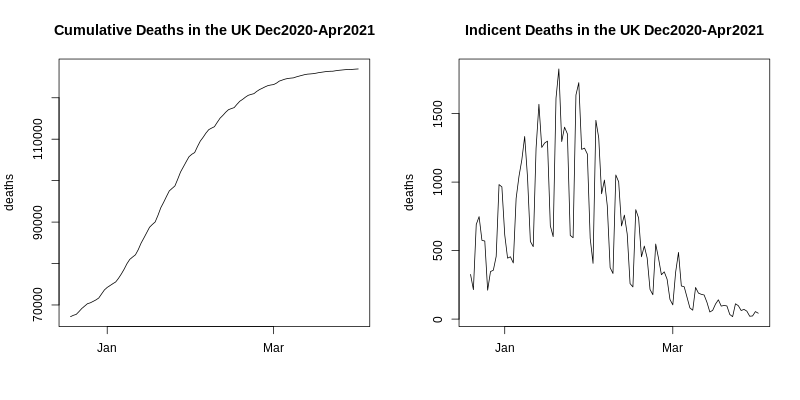

In [12]:
#@title R code: show periodic effect in the UK
%%R -w 800 -h 400

#additivity
#for example the United Kingdom summarizes
example_deaths = covid_global %>%
 filter(location %in% c("United Kingdom")) %>%
 filter(date > "2020-12-18") %>%

 filter(date < "2021-04-01") %>%
 mutate( total_deaths = ifelse(is.na(total_deaths), 0, total_deaths))

par(mfrow= c(1,2))
 plot(example_deaths$date, (example_deaths$total_deaths), type="l",
      xlab='', ylab="deaths",
      main="Cumulative Deaths in the UK Dec2020-Apr2021")
 plot(example_deaths$date[-1],diff(example_deaths$total_deaths), type="l", xlab='',
      main="Indicent Deaths in the UK Dec2020-Apr2021",
      ylab="deaths")
 par(mfrow=c(1,1))

 Instead of following a perfect curve, some days (e.g. the weekends) have less incident deaths than the expected from a ideal curve. Other days (beginning of the week) have proportionally more than expected. These patterns might be caused by the reporting mechanism (e.g. no deaths are reported on weekends) or even more natural causes, such as people interacting more during the weekends, leading to more infections and deaths some days of the week more than others.
  These periodic effects complicate the estimation of the curves from the real data, for example, if we naively fit a Gompertz curve on a Sunday, it can potentially be  quite different to the curve we would get the next day (Monday). We would need to manually take that into account in some clever way, or resign ourselves to some form on averaging that might reduce the information available. It
 might even be the case that there is a subtler effect or more intrincate pattern that is not as easy to deal with (or even see) as the week/weekend.


This kind of systematic nuisance might be **automatically** captured and accounted for in the parameterization as autoregressive process.
This section is devoted to show how this happens.

### Multiplicative periodic patterns
In this specific example, we can think that there is a multiplicative cyclical effect affecting the ideal curve. By multiplicative, we simply mean that some days we will get larger values than expected from the ideal curve, and how much larger depends on the value of the ideal curve for that point in time, it is a proportional effect. This constrast for example with what could be an additive effect, some days we would get larger values than expected, but by a fixed quantity, not proportional to the ideal curve.
 Note that this multiplicative effect is also also an idealization of reality, subject to limitations, but just more adjusted to reality than a ideal curve.

A note: for the case of COVID, the effect is multiplicative on the incidences, not on the cumulative counts of the curve, which changes the analysis. We will proceed as if it was multiplicative on the cumulative count.


A periodic pattern of period $\psi$ is *any function* that satisfies:
$$p(t + \psi) = p(t)$$
Which trivially makes them able to be parameterized as linear autoregressive functions of enough lags.
$$p(t + \psi) = 0p(t +\psi - 1) + \dots + 0p(t + 1) + 1p(t)$$
There might be other autoregressive formulations which do not require
to look $\psi$ observations back in time.

So now we have our original process $l(t)$ that we **assume** can be modeled with an autoregressive function of some form, and a periodic 'nuisance'
process $p(t)$. If the nuisance is additive and $l(t)$ is linear, we know that we will have no problem modeling $l(t) + p(t)$ because it is also linear.

If the nuisance is multiplicative, we have a new process $m(t)$:

$$m(t) = l(t)p(t)$$

What we want to show is that the modified process $m(t)$ can also be modeled autoregressively as a function of its previous time steps without requiring us to observe either $l(t)$ or $p(t)$. This means that we do not even need to know about what is going on underneath, an autoregressive formulation will pick the pattern for us.

Unrolling a period and applying the periodicity property:

$$m(t + \psi) = l(t+\psi)p(t)$$

We notice that if we can model $l(t)$ in a linear autoregressive form we can predict $\psi$ steps ahead by applying the model recursively, which is also linear. For simplicity, we will assume that this $l(t)$ only requires looking back one timestep (lag 1).
$$l(t + 1) = \alpha l(t)$$
$$l(t + 2) = \alpha l(t+1) = a^2 l(t)$$
$$l(t + \psi) = \alpha^{\psi}l(t)$$

For notation, we will assume a function $F$ that can predict $\psi$ steps forward in time (instead of the typicial 1 step ahead).

$$l(t + \psi) = F[l(t)]$$

 We will see how we can capture $m(t)$ by simply adding one period to the autoregressive order.
 Recall:
 $$m(t) = l(t)p(t)$$

Assuming we have no zeros in $p(t)$:
$$l(t) = m(t)/p(t)$$
Then the next 'cycle'.
 $$m(t + \psi) = l(t+ \psi)p(t)$$
  $$m(t + \psi) = F[l(t)]p(t)$$
$$m(t + \psi) = F[m(t)/p(t)]p(t)$$
Considering $F$ linear then we can get $p(t)$ out and have
 $$m(t+\psi) = F[m(t)]$$
And to show it more clearly:
$$m(t + 1) = F[m(t - \psi + 1)]$$

So we can recover an autoregressive process directly on the composed process.

The number of lags (a.k.a. order) of this autoregressive function should be
**at most** $\psi + \text{the original order of } l(t)$. Note that there might be parameterizations that do not require
going back a whole period $\psi$. When $F$ is nonlinear, then 'it depends'.
In our derivation, we had to remove the possibility of zeros in the periodic pattern $p(t)$. There could be better ways to solve that issue, numerical experiments can show that it can be recovered. But as it is, it is actually an interesting insight, because if there are zeros, the information on those time steps is lost. We can 'undo' an arbitrary scaling but not when the values are completely removed. This makes important to try to report the pandemic data each day, every day, not skipping Sundays.

There is an important realization, we can extented this idea from periodic processes to any kind of predictable process, and get a construction rule on how
composition by addition and multiplication is predictable with autoregression if the individual compenents are.

### Experiment with periodic nuisances
We will experiment with a Gomperz curve perturbed with a multiplicative process, to show that it resembles the kind of cyclical patterns (weekly effect) that appear in the real curves such as the UK deaths shown above, and how it is automatically 'solved' by an autoregressive parametrization.
The next plot shows in its first row an ideal Gompertz curve representing the cumulative
counts of a pandemic together with its incedences.
In the second row we plot a periodic pattern that represents some days with 'higher proportion' and others with less proportion of counts. Then we show the modified incidence, multiplying the ideal incidence to this periodic pattern.
See how it resembles the real UK incidence time series. Finally we show the cumulative counts of the multiplicative effect.
In the cumulative counts, the impact of the periodic pattern is very subtle to the naked eye, 
we would need to zoom in a bit to see some form of 'anomaly' with respect to the ideal curve. This is part of the danger, we might intuitively think the
effect is not relevant for cumulative counts, but it will actually affect the predictions.


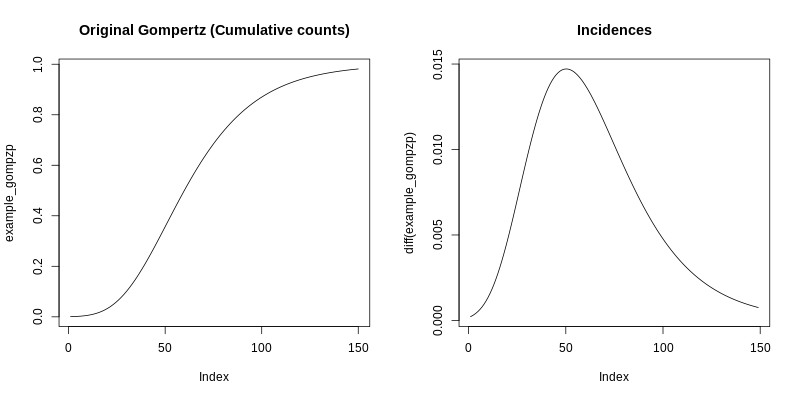

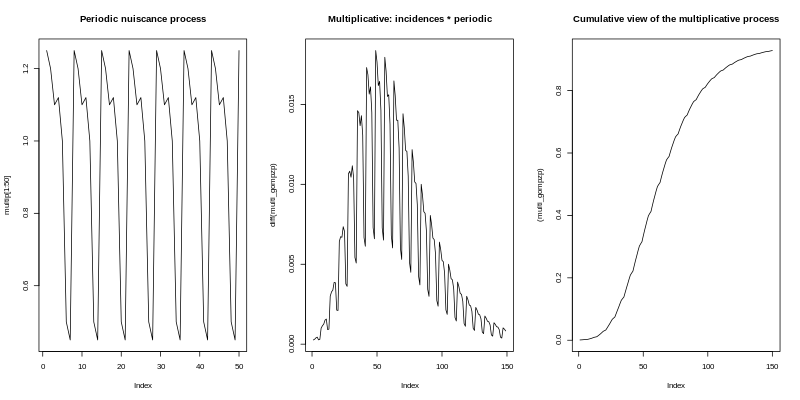

In [13]:
#@title R code: simulation Gompertz with multiplicative periodic nuisance
%%R -w 800 -h 400

recur_forec <- function(model, x, horiz) {
    lag = length(model$coef)
    for (h in 1:horiz) {
        pred = model$coef %*% c(1,rev(tail(x, lag-1)))
        x = c(x, pred)
    }
    x#tail(x, horiz)
}

ts = seq(-0.995, 2, 0.02)
Ap = 1.0
Bp = 1.0
Cp = 2.0
example_gompzp = gompertz(ts, Ap, Bp, Cp)# / Ak

par(mfrow = c(1,2))
plot(example_gompzp, type="l", main="Original Gompertz (Cumulative counts)")
plot(diff(example_gompzp), type="l", main="Incidences")
par(mfrow = c(1,1))

multip = rep(c(1.25, 1.2, 1.10 , 1.12, 1.0, 0.5, 0.45 ), length(example_gompzp))[1:length(example_gompzp)]
par(mfrow = c(1,3))
plot(multip[1:50], type="l", main="Periodic nuiscance process")
multi_gompzp = cumsum(c(example_gompzp[1], diff(example_gompzp))*multip)
plot( diff(multi_gompzp), type="l", main="Multiplicative: incidences * periodic")
plot( (multi_gompzp), type="l", main="Cumulative view of the multiplicative process")
par(mfrow = c(1,1))

err_lags = sapply( 1:24, function (lag) {
    observed_tsteps = 1:50
  Xs = embed((log(multi_gompzp))[observed_tsteps], lag+1)
  Ys = (Xs[,1, drop=FALSE])
  Xs = Xs[,-1, drop=FALSE]

  Xs = cbind(Xs)

  modelm = lm(Ys~Xs)

  modelm$coef[ is.na(modelm$coef)] <- 0


  pred_model = exp(recur_forec(modelm,
                 (log(multi_gompzp))[observed_tsteps],
                 length(multi_gompzp) - max(observed_tsteps)))
  
  png(paste("period_apprx_", lag, ".png", sep=""), width=480*2*0.75, height=480*0.75)
  par(mfrow = c(1,2))
    plot( (pred_model), type="l",
     col="red", main = paste("LAG:", lag), ylim = 1.15*range((multi_gompzp)))
  lines((multi_gompzp), col="black")
  abline(v=max(observed_tsteps))
  plot( diff(pred_model), type="l",
     col="red", main = paste("LAG:", lag), ylim = 1.15*range(diff(multi_gompzp)))
  lines(diff(multi_gompzp), col="black")
  abline(v=max(observed_tsteps))
    par(mfrow = c(1,1))
  #plot(modelm$coef, type="b")
  dev.off()

  mean(abs(pred_model[-observed_tsteps] - multi_gompzp[-observed_tsteps]))
  #mean(abs(modelm$residuals))
})


In the next interactive plot we will see how the multiplicative effect affects the prediction, and how adding more lags into the autoregressive model will mitigate it. We can see the predictions of an autoregressive model as we modify its order of autoregression, the number of lags we consider for the linear model. The vertical line represents the observed part of the time series, the part that is used to fit the model. The red line to the right of the vertical line would be the predictions. We choose the plotting instead of just giving raw numbers to increase the interpretability of the result.
 Some highlights of what we should look for in the interactive plot:
1. At `lag=1`, or order 1, the order is not enough for capturing the ideal
Gompertz curve. We see that with the multiplicative periodic effect, the predictions are way off. Interestingly, when we look at incidence curve, the
predictions are 'qualitatively' OK, they look realistic, just very off.
2. The approximation improves when we increase the `lag`. When we get to `lag=8`, we see a big change in the accuracy of the predictions with respect to the previous lags, like it suddenly 'clicks'.
This change represents the period of the periodic pattern (7) + the original
order (1). Note that `lag=7` is not enough, even though it could capture the periodic disturbation on its own.
3. The approximation and `lag=8` is very good, but it is not perfect. We get better approximations if we increase the lag order even more. **This is because our example is multiplicative on the incidences, not on the cumulative, so our assumptions are not totally met.**


In [14]:
#@title Python: Interactive plot effect of lag in pick the periodicity
from IPython.display import Image
#Image('tmp.png')

#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

@interact(lag=widgets.IntSlider(min=1, max=21, step=1, value=1))
def show_period(lag):
    return Image("period_apprx_" + str(lag) + ".png")

interactive(children=(IntSlider(value=1, description='lag', max=21, min=1), Output()), _dom_classes=('widget-i…

### Data pooling of different periodic patterns in different curves 
**WORK IN PROGRESS SECTION.**

We show the comparatively beneficial effect on data pooling when we have periodic perturbations.

All types of periodicity with the same period are solved by increasing the lag order of the autoregressive model. This leads to another 'beneficial' practical comparison of data-pooled autoregressions compared to individual autoregressions. Both methods need to add lags to capture the periodicity, but now the data-pooled has to add relatively fewer. For example, working with linear autoregressions models, if the time series in the dataset have a periodic effect of period 7 composed with a main linear process of order 1, the individual autoregressive method needs order = 8 to model a process perfectly, and the data pooled needs order = $8+\text{number_of_series in the pool}$, *even when the periodic pattern are different (as long the same period)*.
In many practical situations either the period is larger than the autoregressive order OR the autoregressive order is relatively large, so what we get it that for a 'comparatively' slightly larger order the data-pooled method will work on many more data. As an examble, imagine we have 5 series in our pool. Each individual model needs to fit 8 parameters, a total of 40 parameters are being fit to data considering the 5 time series. The data-pooled version needs to fit 13 parameters to get to the same level of approximation than the individual.

The followind plot shows a data-pooled model of lag 11 fitting and predicting 'perfectly' 4 different curves, each with its own periodic pattern (all of period 7).

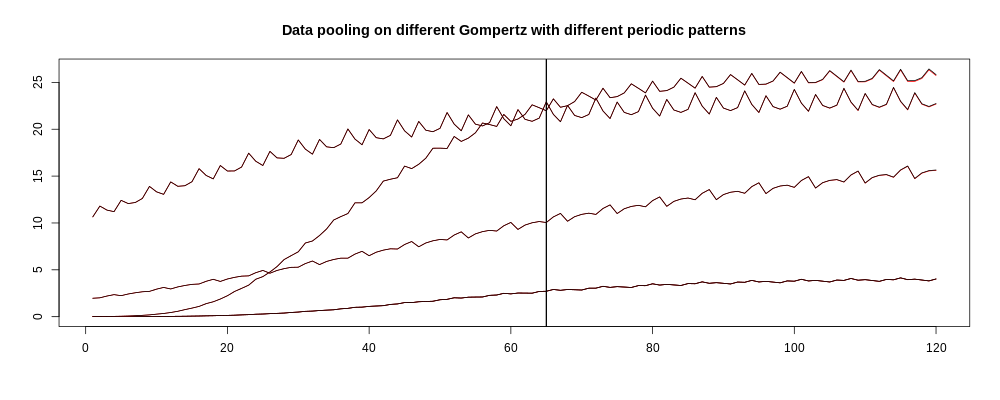

In [15]:
#@title TO DO: Example of pooling with periodicity
%%R -w 1000 -h 400

ts = seq(-0.995, 2, 0.025)

period = 7
ncurves = 4
lag = 11
observed_tsteps = 1:65

all_nuis_gompz = NULL
Xg = NULL
set.seed(1234)



for (nc in 1:ncurves) {
Ap = runif(1, 1.0, 26)
Bp = runif(1, 0.1, 2.0)
Cp = runif(1, 0.1, 3.0)
sim_gompzp = gompertz(ts, Ap, Bp, Cp)# / Ak

#par(mfrow = c(1,2))
#plot(example_gompzp, type="l", main="Original Gompertz (Cumulative counts)")
#plot(diff(example_gompzp), type="l", main="Incidences")
#par(mfrow = c(1,1))


period_nuis = sample(1:10,  period, replace=TRUE)
period_nuis = 1 + 0.5*period_nuis / sum(period_nuis)
#period_nuis = 1
period_nuis = rep(period_nuis, length(sim_gompzp))[1:length(sim_gompzp)]
#nuis_gompzp = cumsum(c(sim_gompzp[1], diff(sim_gompzp))*period_nuis)
nuis_gompzp = (sim_gompzp)*period_nuis
#par(mfrow = c(1,3))
#plot(period_nuis[1:50], type="l", main="Periodic nuiscance process")
#plot( diff(nuis_gompzp), type="l", main="Multiplicative: incidences * periodic")
#plot( (nuis_gompzp), type="l", main="Cumulative view of the multiplicative process")
#par(mfrow = c(1,1))
all_nuis_gompz[[nc]] = nuis_gompzp
Xg = rbind(Xg, embed(nuis_gompzp[observed_tsteps], lag+1))
}
Xg = log(Xg)
Yg = Xg[,1]
Xg = Xg[,-1]

#print(summary(lm(Yg~Xg -1)))
  modelm = lm(Yg~Xg-1)
 modelm$coef = c(0, modelm$coef)
     modelm$coef[ is.na(modelm$coef)] <- 0

plot(all_nuis_gompz[[1]], type="l", ylim=range(unlist(all_nuis_gompz)),
     xlab="", ylab="",
     main="Data pooling on different Gompertz with different periodic patterns")


for (nc in 1:length(all_nuis_gompz)) {
    cur_nuis_gompz = all_nuis_gompz[[nc]]
   

    pred_model = exp(recur_forec(modelm,
                 (log(cur_nuis_gompz))[observed_tsteps],
                 length(cur_nuis_gompz) - max(observed_tsteps)))
    lines(pred_model, col="red")
   lines(all_nuis_gompz[[nc]])
   abline(v=max(observed_tsteps))

}


## 4.2) Additivity
There is one very clear example of meaningful deviation from the ideal curve.
It is the presence of several 'waves' in the pandemic. For example, in the following figure we see that the deaths in the UK from Feb 2020 to May 2021 has two separate waves (seems like 3), therefore it cannot  be captured with a single Gompertz curve. In red, a 'best fit' Gomperzt curve approximating the real data.


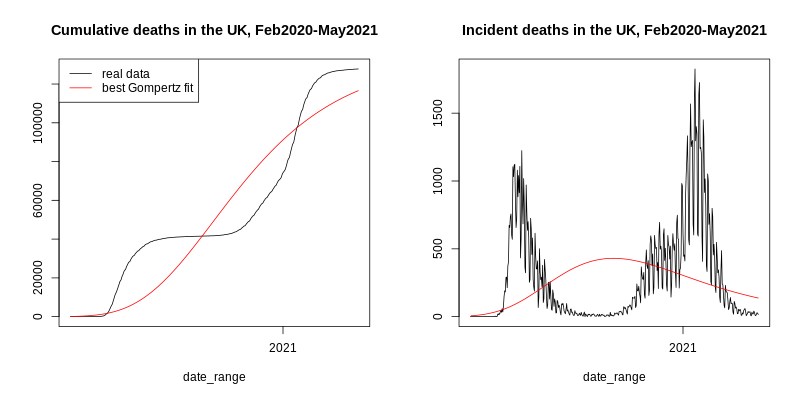

In [16]:
#@title R code: plot UK deaths several waves
%%R -w 800 -h 400

#additivity
#for example the United Kingdom summarizes
uk_deaths = covid_global %>%
 filter(location %in% c("United Kingdom")) %>%
 filter(date < "2021-05-01") %>%
 mutate( total_deaths = ifelse(is.na(total_deaths), 0, total_deaths))
 #ggplot(aes(x=date, y=total_deaths, color=location)) +
 #geom_line()

ukd_norm = max(uk_deaths$total_deaths)



date_range = uk_deaths$date
country_deaths = uk_deaths$total_deaths / ukd_norm #normalize for numerical reasons
t_base = 1:length(country_deaths) / length(country_deaths)
t_base = 2*(t_base - max(t_base)/2)

#w_srch = grid_optim(country_deaths, t_base, n.grid = 200)

w_srch = c(1.0427136, 0.9874372, 2.0000000)
fitted_gompertz = gompertz(t_base, w_srch[1],
                           w_srch[2],
                           w_srch[3])

par(mfrow= c(1,2))
plot(date_range, country_deaths*ukd_norm, type="l", ylab="",
     main = "Cumulative deaths in the UK, Feb2020-May2021")
lines(date_range, fitted_gompertz*ukd_norm, col="red")
legend("topleft", col=c("black", "red"),
       legend=c("real data", "best Gompertz fit"), lty=1)
plot(date_range, c(0,diff(country_deaths*ukd_norm)), type="l", ylab="",
     main =  "Incident deaths in the UK, Feb2020-May2021")
lines(date_range, c(0,diff(fitted_gompertz*ukd_norm)), col="red")
par(mfrow=c(1,1))


Following on that idea we can identify the property of additivity as a simple mechanism that might generate real observed time series that deviate from our ideal curve families in a meaningful way. In general, the sum of two Gompertz curves is not a Gompertz curve (this might also be applicable to other models such as SIR). Two relevant situations that require additivity:

1. The appearance of several 'waves' clearly does not follow an 'S' shape, it rather follows several 'S' stacked on top of each other, which would correspond to a sum of Gompertz curves, one for each wave.
2. The aggregation of subregions. For example, if we assume each region within a country (e.g. states in the US) follows a different Gompertz, the whole country (US) will not follow a Gompertz in because it is just the sum of each individual state. In the next plot we see the confirmed cases time series for the states of New York, California and Texas. We can see that the have qualitatively different behaviors, in the period from March-Jul 2020, New York has 'peaked' while California and Texas are stilly rapidly increasing. 
The time series for the US, resulting by summing these (and some others), will deviate from the 'shape' of an ideal Gompertz curve.


In [17]:
#@title R code download UK nations cases
%%R
us_region_cases <- read_csv("https://github.com/CSSEGISandData/COVID-19/blob/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv?raw=true")

Rows: 3342 Columns: 1142
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr    (6): iso2, iso3, Admin2, Province_State, Country_Region, Combined_Key
dbl (1136): UID, code3, FIPS, Lat, Long_, 1/22/20, 1/23/20, 1/24/20, 1/25/20...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


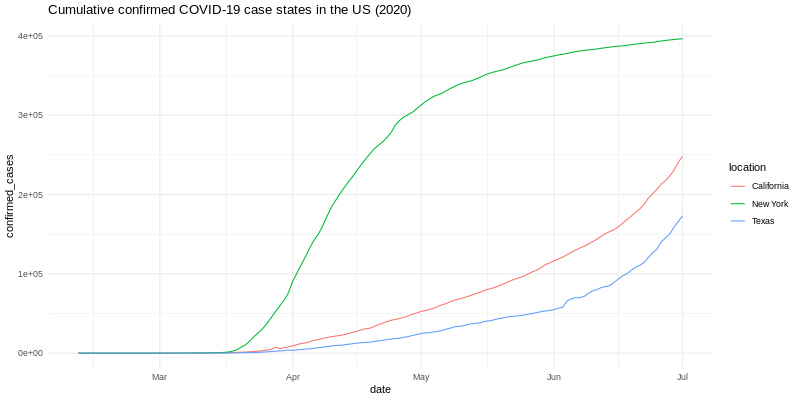

In [18]:
#@title R code plot US states confirmed cases first wave
%%R -w 800 -h 400

us_states_cases <- us_region_cases %>% rename(location = `Province_State`) %>%
    select(-`Country_Region`, -Lat, -Long_, -UID, -iso2, -iso3, -code3, -FIPS, -Admin2, -Combined_Key) %>%
    pivot_longer(-c("location")) %>%
    rename(date = name) %>%
    mutate(date = as.Date(date, "%m/%d/%y"))
us_states_cases <- us_states_cases %>% group_by(location, date) %>%
summarize(value = sum(value), .groups="drop") %>%
rename(confirmed_cases=value)

us_states_cases %>%
arrange(date) %>%
filter(date >= "2020-02-11") %>%
filter(date <= "2020-07-01") %>%
filter(location %in% c("New York", "California", "Texas")) %>%
ggplot(aes(x=date, y=confirmed_cases, color=location )) +
 geom_line() + theme_minimal() +
 ggtitle("Cumulative confirmed COVID-19 case states in the US (2020)")


There are 'workarounds' for these issues that allow us to
keep using Gompertz curves. For example, in the case of two clearly separated waves we can try to find the 'cutting point' between the two curves and then fit a curve to each part. In the case of regional aggregation, we can work from the regional time series and just add up the predictions, instead of finding the curve for the aggregated series. A more general solution would be fitting several curves to a single time series, trying to find the best 'sum of curves' that fits the data. However, these workarounds involve new difficulties: How to find the cutting points? What is to say the regions themselves are not also the sum of underlying subregions that are not measured? How many curves should we try to fit simultaneously, and how easy is the simultaneous fitting?.



### Capturing additivity with autoregressive models


We can think of what happens if we aggregate
two Gompertz, $f(t)$ and $r(t)$, the sum result is:

$$s(t) = f(t) + r(t) $$
$$s(t) = Ae^{-Be^{-Ct}} + Xe^{-Ye^{-Zt}} $$

We can try to unroll the process to find an autoregressive formulation.
$$s(t+1) = Ae^{-Be^{-Ct -C}} + Xe^{-Ye^{-Zt - Z}} $$

However, in this case **I could not find a nice autoregressive formulation for the sum of two exponential curves**, so what remains is to reason by
how increasingly more complex autoregressive models can or might approximate arbitrary curves.

#### Experiment with additivity

We will do a numerical experiment in which we create two different Gompertz curves and sum them up, resulting in what can be considered a pandemic
with two waves that overlap a bit. We will fit a linear autoregressive
model with data up until one point in time, the `last_observed_tstep`.
We can choose the number of lags that the autoregressive model will use with
`lag_order`. The autoregressive model is linear **without applying logarithm transform**, this is because the logarithm is not helpful in simplifying the sum of Gompertz curves.

We can visualize the results in the next interactive plot.
We will see that, in general, predictions are accurate for 'near future' time frames, a few time steps ahead from the last observed time step. Then the errors might explode after that, producing absurd predictions. There is a combination of problems going on:
* Excessive generality of autoregressive models. Some predictions go far into negative numbers, which is clearly impossible in our context. We could mitigate this problem by restricting our models to the ones that do not produce this effect.
* Accumulation of error, numerical instability. Even very small numerical errors in the predictions quickly accrue over time when doing prediction with autoregressive models for very long future horizons. This problem can be mitigated with techniques such as multi-step ahead prediction.

**Taking into account the limitations of this experiment**,
we highlight several effects of interest.
* During the first wave, at `last_observed_tstep=45` and lag orders around `lag_order=25` produces good predictions for the short term.
* After the first peak, at `last_observed_tstep=125` and `lag_order=25`
   see how an AR model correctly correctly predicts the 'inflection' point of the incidences, when the second wave takes over. This is an important qualitative difference, because a single Gompertz curve cannot reproduce this 'decrease-increase' behavior in the incidences . If we increase the `lag_order` to something
   like 80 the approximation is accurate many more time steps into the future. **This is the message of the experiment, an AR model can detect this extra complexity w.r.t. a ideal Gompertz curve.**
* You can check how the two waves effect is increasingly better captured the closer we get to it. Set `lag_order=25` and `last_observed_tstep=75`, just after the first peak. Then slowly move the slider from `last_observed_tstep=75` to `last_observed_tstep=150`.
* When we are well into the second wave,  at `last_observed_tstep=250` smaller orders such as `lag_order=25` work relatively well for the short term. However,
much longer lag orders such as `lag_order=150` predict the remaining of the curve much more accurately until longer horizons. Smaller lag orders fail to capture this, we can argue that longer lags are 'removing the effect' from the first wave automatically.
* There are many combinations of `lag_order` and `last_observed_tstep` that produce absurd results such as cumulative curve going down (negative incidences) which we know are impossible. (Try `lag_order=2` for values of many `last_observed_tstep`). On the other hand, this generality allows us to capture other effects such as the inflection point between the two waves that would be impossible to capture with a single Gompertz curve.

In [19]:
#@title R code: simulating 2 waves by summing 2 gompertz, pick the effect with linear AR
%%R
## CREATING A SUM OF TWO GOMPERTZ ##
## APPROXIMATION WITH MORE LAGS
additive_example_plot = function(lag, last_observed_tstep) {
    sum_gompz = 0
    ts =  seq(-1.1, 1.7, 0.015/3)
    set.seed(1234567)

    par_A = c(2, 12)
    par_B = c(0.01, 2.5)
    par_C = c(6, 2.0)#c(2, 2)

  indiv_gompz = NULL
  for (k in 1:2) {
   Ak = par_A[k] #runif(1, 1, 4) #sample(c(0.5, 2, 4), 1) #runif(1, 1, 4) #
   Bk = par_B[k] #runif(1, 0.5, 3) #sample(c(0.1,2, 5),1)#(runif(1, 0.01, 10)) #
   Ck = par_C[k] #runif(1, 1, 4) #sample(c(0.5, 2, 3), 1) #(runif(1, 0.1, 5)) #
   example_gompzk = gompertz(ts, Ak, Bk, Ck)# / Ak
   indiv_gompz[[k]] = example_gompzk
   #example_gompzk = c(rep(0, 25), example_gompzk)# + 0.0001
   #example_gompzk = cumsum(c(0, diff(example_gompzk)) *(sin(90*ts) + 1))
   #if (k == 1) next;
   sum_gompz  = (example_gompzk) + sum_gompz
 }


  warn_too_much_lag = FALSE
  orig_lag = lag
  if ( lag >= last_observed_tstep-1) {
      lag = last_observed_tstep -2
      warn_too_much_lag = TRUE
  }

 observed_tsteps = 1:last_observed_tstep
  Xs = embed((sum_gompz)[observed_tsteps], lag+1)
  Ys = (Xs[,1, drop=FALSE])
  Xs = Xs[,-1, drop=FALSE]
 
  modelm = lm(Ys~Xs)
  modelm$coef[ is.na(modelm$coef)] <- 0
  modelm$lag <- lag

  pred_model = (recur_forec(modelm,
                 ((sum_gompz))[observed_tsteps],
                 length(sum_gompz) - max(observed_tsteps)))

  png(paste('add_exam_plot_', orig_lag,
            '_', last_observed_tstep, '.png', sep=""), width=800, height=400)
    par(mfrow=c(1,2))
  plot( (pred_model), type="l",
     col="red", main = paste("LAG:", lag), ylim = 1.15*range((sum_gompz)))
  lines((sum_gompz), col="black")
  abline(v=max(observed_tsteps))
    plot( diff(pred_model), type="l",
     col="red", main = paste("LAG:", lag), ylim = 1.15*range(diff(sum_gompz)))
  lines(diff(sum_gompz), col="black")
  abline(v=max(observed_tsteps))
  par(mfrow=c(1,1))
  dev.off()
}

#additive_example_plot(50, 41)

In [20]:
#@title python: Interactive plot of picking 2 simulated waves with linear model
from IPython.display import Image

#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import datetime
import rpy2.robjects as robjects
from ipywidgets import Button, Layout

style = {'description_width': 'initial'}



rplotfun_add = robjects.r['additive_example_plot']

def show_additivity(lag_order, last_observed_tstep):
    rplotfun_add( lag_order, last_observed_tstep)
    return Image('add_exam_plot_'+ str(lag_order) + '_' +
                 str(last_observed_tstep) + '.png')

interact(show_additivity, 
         lag_order=widgets.IntSlider(min=1, max=150, step=1, value=8,
                                     layout=Layout(width='50%', height='18px')),
         last_observed_tstep = widgets.IntSlider(min=15, max=350, step=1, value=85,
                                                 style=style,
                                                 layout=Layout(width='50%', height='18px')));

interactive(children=(IntSlider(value=8, description='lag_order', layout=Layout(height='18px', width='50%'), m…

## 4.3) Noise

We will show a numerical example with noise added to simulated Gompertz curves. 
The main takeaway is that there is another 'beneficial' effect of data-pooled autoregression in practical applications: both individual and data-pooled autoregressive models require more lags (higher order) to mitigate the effects of noise, but the increase in model complexity is smaller for data-pooled models relative to the amount of extra data that they gain from pooling.

A difference between autoregression and curve-based is made evident in this experiment. Curve-based models do not need to be altered in the presence of noise. If a particular curve-based model is OK without noise, then it will be OK when noise is added, even though we might need to change the way the curve is fitted to data. The caveat is how to find the correct curve-based model and how to adapt the fitting method in order to get good predictions.

The experiment simply extends the many curves experiment in Section 3 by adding gaussian noise to the ideal curves. Specifically, it is positive gaussian noise (the absolute value of a Gaussian) because there cannot be negative values in the cumulative curves. The standard deviation of the gaussian is inversely proportional to the value of the curve, to prevent the noise from dominating the error level at the later phases of each curve. The effect is introduced multiplicative. Highlight that this experiment is **unrealistic**: We might all agree that pandemic data measurements (cases, deaths, etc.) are subjected to some irreducible noise, but it certainly does not look like the type we are experimenting with here. Neither a simulated gaussian is truly random so this experiment can be understood as an example of a 'very complex nuisance pattern' rather than as a 'plausible nuisance' in the spirit of the two previous examples (periodicity and additivity). It serves as an example for **perturbations that cannot be captured with the models that we are using**.

The following summary plot shows the relationship between the noise level and the prediction error in a dataset of 15 different Gompertz curves. The noise level is the scale of the standard deviation of the simulated gaussian, linear scale. The error measure is mean absolute error of the predictions for all curves. The results come in pairs of lines, representing the error of individual (blue) and data-pooled (green) models for different lag orders: 4, 8, 16, 32.

We start with are two general observations:
 * Prediction error grows with the noise level.
 * **Prediction error decreases with the lag order** for both individual and data-pooled models. This is the main story: autoregressive models need more lags
 to mitigate the effect of noise. We do not have a rigorous argument but the intuitition, more past observations need to be used in order to average out the noise in autoregressions.
 For example, if what we observe is only noise, say white noise, the optimal prediction (according to absolute error or squared error) is a constant, the mean of the observed time series. An autoregressive model, say linear of order $L$ (no intercept), can 'predict the mean' with all coefficients being $\frac{1}{L}$. The larger the order $L$, the better we can approximate the mean with autoregressions. Then we conjecture that when the 'unadultered' process is not a constant but follows some curve-like pattern, the same principle applies, more lags are needed to 'smooth out' the effect of noise.

There are non-trivial interactions between noise level, lag orders and pooling.

* All lag orders have a 'crossing point' for the noise level beyond which the data-pooled model starts outperforming the individual.
 * There is a regime where individual models perform better than the pooled.
   This is the same regime as in the absence of noise, where the individual models require very few lags, while the pooled model requires lags which increase with the number of series in the pool.
 * The 'beneficial' effect of data pooling is observed. Larger orders are required to mitigate noise, for example for `noise_level=50` `lag=8` does better than `lag=4`, `lag=16` does even better than `lag=8`, for both individual and pooled. But for `lag=32`, the error of the individual model explodes, while the data pooled model keeps improving. There is not enough data in a individual time series to fit an autoregressive model.
 * The noise level at which the crossing point appears is not 'monotonic' with the lag order. It seems to follow that the larger the order, the more noise required for the 'crossing' but then for `lag=32` the crossing point appears much sooner. The shape of the error line is qualitatively different, from a 'logarithmic' relationship with noise to a 'exponential'.

In [21]:
#@title R code Example of pooling with noise
%%R -w 1000 -h 400

noise_pool_exp = function(lag, max_tstep, num_curves, noise_level, seed=1234, do_print=TRUE) {
  ts = seq(-0.995, 2, 0.015)
  all_err_indiv = NULL
  all_err_pool = NULL

  all_noise_gompz = NULL
  indiv_preds = NULL
  Xg = NULL
  observed_tsteps = 1:max_tstep
  set.seed(seed)
  noise_float = noise_level / 200

  for (nc in 1:num_curves) {
    Ap = runif(1, 1.0, 8)
    Bp = runif(1, 0.1, 2.0)
    Cp = runif(1, 0.1, 3.0)
    sim_gompzp = gompertz(ts, Ap, Bp, Cp)# / Ak

    noise_sig = 1+abs(rnorm(length(sim_gompzp), 0, noise_float/abs(sim_gompzp+1)))
    noise_gompz = (sim_gompzp)*noise_sig

    #data pooling
    all_noise_gompz[[nc]] = noise_gompz
    Xg = rbind(Xg, embed(noise_gompz[observed_tsteps], lag+1))
    #fit individual model to each series
    X_ind = embed(noise_gompz[observed_tsteps], lag+1)
    X_ind = log(X_ind)
    Y_ind = X_ind[, 1, drop=FALSE]
    X_ind = X_ind[,-1, drop=FALSE]
    model_ind = lm(Y_ind~X_ind-1)
    model_ind$coef = c(0, model_ind$coef)
    model_ind$coef[ is.na(model_ind$coef)] <- 0
    pred_ind = exp(recur_forec(model_ind,
                 (log(noise_gompz))[observed_tsteps],
                 length(noise_gompz) - max(observed_tsteps)))
    indiv_preds[[nc]] <- pred_ind

  }
  #fit data-pooled model
  Xg = log(Xg)
  Yg = Xg[,1, drop=FALSE]
  Xg = Xg[,-1, drop=FALSE]
  modelm = lm(Yg~Xg-1)
  modelm$coef = c(0, modelm$coef)
  modelm$coef[ is.na(modelm$coef)] <- 0

  colorpal = heat.colors(length(all_noise_gompz))
  png(paste('noise_plot_', lag,
            '_', max_tstep, '_', num_curves, '_',
            noise_level, '.png', sep=""), width=800, height=400)

  plot(all_noise_gompz[[1]], type="l", ylim=1.25*range(unlist(all_noise_gompz)),
       xlab="", ylab="", col=colorpal[1],
       main="")

  err_indiv = 0
  err_pool = 0
  for (nc in 1:length(all_noise_gompz)) {
    cur_nuis_gompz = all_noise_gompz[[nc]]
    pred_model = exp(recur_forec(modelm,
                 (log(cur_nuis_gompz))[observed_tsteps],
                 length(cur_nuis_gompz) - max(observed_tsteps)))
    lines(pred_model, col="green")
    lines(indiv_preds[[nc]], col="blue")
    lines(all_noise_gompz[[nc]][observed_tsteps], lwd=2, col=colorpal[nc])
    lines(all_noise_gompz[[nc]], lwd=1, col=colorpal[nc])
    abline(v=max(observed_tsteps), lty=2)
    err_indiv = err_indiv + mean(abs(cur_nuis_gompz - indiv_preds[[nc]])[-observed_tsteps])
    err_pool = err_pool + mean(abs(cur_nuis_gompz - pred_model)[-observed_tsteps])
  }
  dev.off()
  if (do_print) {
    print(paste("Individual AR error:", round(err_indiv/num_curves, 2), "|",
                "Pooled AR error:", round(err_pool/num_curves, 2)))
  }
  list(err_indiv=err_indiv, err_pool=err_pool)
}

In [22]:
#@title R code running simulation noise vs error vs lags
%%R

noise_range = 0:50
compar_noise = function(clag) {

  sapply(noise_range, function(noise) {
    lerrs = lapply(1:15, function(lseed) {
        noise_pool_exp(lag=clag, max_tstep=95, num_curves=15,
                       noise_level=noise, seed=lseed, do_print=FALSE)
        })
  errmat = sapply(lerrs, function(x) unlist(x))
  round(rowMeans(errmat),2) })
}

#disabled for computational reasons
if (0) {
errs_per_level_l4 = compar_noise(4)
errs_per_level_l8 = compar_noise(8)
errs_per_level_l16 = compar_noise(16)
errs_per_level_l32 = compar_noise(32)
}

In [23]:
#@title R code for precalculated results of the experiment
%%R

errs_per_level_l4 = structure(c(0, 0.16, 3.05, 8.94, 6.72, 10.63, 10.36, 12.86, 13.76, 
15.27, 16.82, 17.62, 19.51, 19.76, 21.9, 21.64, 23.99, 23.25, 
25.84, 24.61, 27.46, 25.75, 28.87, 26.71, 30.12, 27.51, 31.22, 
28.19, 32.21, 28.77, 33.1, 29.26, 33.9, 29.69, 34.63, 30.06, 
35.28, 30.38, 35.88, 30.66, 36.43, 30.92, 36.94, 31.14, 37.4, 
31.34, 37.82, 31.53, 38.21, 31.69, 38.59, 31.85, 38.95, 31.99, 
39.28, 32.12, 39.59, 32.24, 39.88, 32.36, 40.15, 32.46, 40.39, 
32.56, 40.63, 32.66, 40.84, 32.75, 41.04, 32.83, 41.22, 32.92, 
41.39, 32.99, 41.55, 33.07, 41.7, 33.14, 41.83, 33.21, 41.96, 
33.28, 42.07, 33.35, 42.18, 33.41, 42.27, 33.47, 42.36, 33.53, 
42.44, 33.59, 42.51, 33.65, 42.57, 33.7, 42.63, 33.76, 42.68, 
33.81, 42.73, 33.87), .Dim = c(2L, 51L), .Dimnames = list(c("err_indiv", 
"err_pool"), NULL))

errs_per_level_l8 = structure(c(0, 0.02, 0.97, 6.9, 2.01, 7.9, 3.07, 8.29, 4.14, 
8.62, 5.2, 9, 6.26, 9.44, 7.3, 9.92, 8.33, 10.44, 9.35, 11, 10.34, 
11.58, 11.32, 12.19, 12.28, 12.81, 13.24, 13.44, 14.18, 14.07, 
15.09, 14.7, 15.98, 15.33, 16.83, 15.95, 17.66, 16.57, 18.48, 
17.17, 19.27, 17.76, 20.03, 18.33, 20.77, 18.89, 21.49, 19.43, 
22.19, 19.96, 22.87, 20.46, 23.53, 20.96, 24.16, 21.43, 24.78, 
21.89, 25.37, 22.33, 25.95, 22.75, 26.52, 23.16, 27.08, 23.55, 
27.63, 23.93, 28.15, 24.29, 28.67, 24.64, 29.16, 24.97, 29.64, 
25.3, 30.1, 25.61, 30.54, 25.91, 30.98, 26.19, 31.4, 26.47, 31.8, 
26.74, 32.2, 26.99, 32.58, 27.24, 32.95, 27.48, 33.31, 27.71, 
33.66, 27.93, 34, 28.14, 34.32, 28.35, 34.64, 28.55), .Dim = c(2L, 
51L), .Dimnames = list(c("err_indiv", "err_pool"), NULL))

errs_per_level_l16 = structure(c(0, 0, 0.36, 1.71, 0.73, 2.76, 1.09, 4.05, 1.45, 5.08, 
1.82, 5.82, 2.17, 6.36, 2.51, 6.74, 2.84, 7.03, 3.17, 7.24, 3.49, 
7.42, 3.82, 7.56, 4.13, 7.69, 4.45, 7.8, 4.77, 7.9, 5.09, 8, 
5.41, 8.09, 5.72, 8.18, 6.04, 8.27, 6.35, 8.35, 6.65, 8.44, 6.96, 
8.53, 7.26, 8.62, 7.56, 8.72, 7.86, 8.81, 8.15, 8.91, 8.45, 9.01, 
8.74, 9.11, 9.03, 9.21, 9.32, 9.31, 9.6, 9.42, 9.89, 9.52, 10.17, 
9.63, 10.45, 9.74, 10.72, 9.85, 10.99, 9.97, 11.26, 10.09, 11.53, 
10.2, 11.79, 10.32, 12.05, 10.45, 12.32, 10.57, 12.58, 10.7, 
12.84, 10.82, 13.1, 10.95, 13.35, 11.08, 13.61, 11.21, 13.86, 
11.34, 14.11, 11.48, 14.36, 11.61, 14.61, 11.74, 14.86, 11.88
), .Dim = c(2L, 51L), .Dimnames = list(c("err_indiv", "err_pool"
), NULL))

errs_per_level_l32 = structure(c(0, 0, 0.22, 1.54, 0.45, 1.81, 0.68, 1.95, 0.92, 2.08, 
1.18, 2.21, 1.46, 2.36, 1.77, 2.52, 2.12, 2.68, 2.53, 2.85, 3.01, 
3.01, 3.59, 3.18, 4.28, 3.35, 5.11, 3.52, 6.13, 3.68, 7.38, 3.85, 
8.91, 4, 10.8, 4.15, 13.11, 4.3, 15.93, 4.43, 19.37, 4.57, 23.54, 
4.7, 28.57, 4.82, 34.59, 4.94, 41.76, 5.06, 50.24, 5.17, 60.2, 
5.27, 71.82, 5.38, 85.28, 5.47, 100.76, 5.57, 118.45, 5.66, 138.52, 
5.75, 161.15, 5.84, 186.47, 5.93, 214.63, 6.01, 245.75, 6.09, 
279.91, 6.17, 317.18, 6.24, 357.6, 6.32, 401.16, 6.38, 447.85, 
6.45, 497.61, 6.52, 550.33, 6.58, 605.9, 6.64, 664.16, 6.7, 724.92, 
6.76, 787.98, 6.81, 853.1, 6.87, 920.01, 6.92, 988.45, 6.97, 
1058.13, 7.02), .Dim = c(2L, 51L), .Dimnames = list(c("err_indiv", 
"err_pool"), NULL))





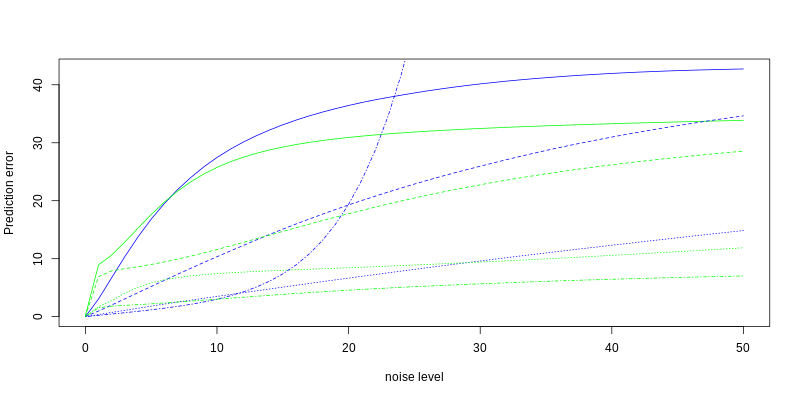

In [24]:
#@title R code plot relation error vs noise level for individual and pooled model 
%%R -w 800 -h 400

plot(noise_range, errs_per_level_l4[1,], type="l", col="blue",
     xlab="noise level", ylab="Prediction error")
lines(noise_range, errs_per_level_l4[2,], col="green")

lines(noise_range, errs_per_level_l8[1,], type="l", col="blue", lty=2)
lines(noise_range, errs_per_level_l8[2,], col="green", lty=2)

lines(noise_range, errs_per_level_l16[1,], type="l", col="blue", lty=3)
lines(noise_range, errs_per_level_l16[2,], col="green", lty=3)

lines(noise_range, errs_per_level_l32[1,], type="l", col="blue", lty=4)
lines(noise_range, errs_per_level_l32[2,], col="green", lty=4)


The experiment can be analyzed in depth in the next interactive plot.
Instead of noise vs error, we plot the time series and the forecasts of the individual and data-pooled autoregressions, summarizing errors in text. We can control the number of series,
the noise level, the order of the autoregression and how many time steps are observed before forecasting. The time series can be used to understand the 'difficulty' of the problem and the quality of the forecasts beyond the average error numbers of the previous static figure.

Some highlights on what to look for in the next interactive plot:

 * Move the `lag_order` slider to see how individual and pooled need large orders to improve the prediction.
 * The individual model requires smaller lag order to produce its best predictions compared to the pooled.
 * Larger `lag_order` cause the individual model to produce absurd predictions much sooner than the pooled.
 * For some combinations, the poor performance of the individual models is due to them predicting 'too large' values. Poor performance of pooled tends to be predictions towards a small value, 1.
 * At `noise_level=0` it replicates the experiment of Section 3, on how linear
 autoregressions are able to fit several different curves. It can be seen that we do not need as many lags as time series to get virtually perfect predictions with the pooled model.
 * Increasing the lag order makes the the pooled model outperform the 'optimal'
   individual model at most `noise_level`x`num_curves` combinations.  
 * The more series we have in the pool, the more lags we need to get the best performance. The more noise level, the more lags. A simple pooled linear model might reach the maximum number of lags available in the data. In this experiment we can control `last_observed_tstep` to produce a situation where the number of possible lags is not enough for the pooled model. For `last_observed_tstep=55`, `num_curves=15`, `noise_level=1`, there is no `lag_order` that allows the pooled model to outperform the best individual.

In [25]:
#@title python: Interactive plot of data-pooling with noise
from IPython.display import Image

#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import datetime
import rpy2.robjects as robjects
from ipywidgets import Button, Layout

style = {'description_width': 'initial'}



rplotfun_noise = robjects.r['noise_pool_exp']

def show_noise_pool(lag_order, last_observed_tstep, num_curves, noise_level):
    rplotfun_noise(lag_order, last_observed_tstep, num_curves, noise_level);
    return Image('noise_plot_'+ str(lag_order) + '_' +
                 str(last_observed_tstep) + '_' +
                 str(num_curves) + '_' + str(noise_level) +'.png')

interact(show_noise_pool, 
         lag_order=widgets.IntSlider(min=2, max=100, step=1, value=2,
                                     layout=Layout(width='50%', height='18px')),
         last_observed_tstep = widgets.IntSlider(min=55, max=150, step=1, value=85,
                                                 style=style,
                                                 layout=Layout(width='50%', height='18px')),
         num_curves = widgets.IntSlider(min=2, max=15, step=1, value=7, style=style,
                                        layout=Layout(width='50%', height='18px')),
         noise_level = widgets.IntSlider(min=0, max=100, step=1, value=50, style=style,
                                         layout=Layout(width='50%', height='18px')));

interactive(children=(IntSlider(value=2, description='lag_order', layout=Layout(height='18px', width='50%'), m…



## 4.4) Solving Deviations : Tradeoff
**TO DO Section**

* We have seen that we catch deviations such as
  Periodicity and Additivity through AR by adding lags.
* The problem is that in realistic scenarios, we cannot fit such complex
 AR models to a single time series, might not be enough data or it may overfit.

* The argument is to solve this issue with data pooling, if we can get
 a 'benevolent' effect either through not requiring that many more
 lags or through catching them through nonlinearities.


####  **TO DO** An example data pooling for a sum curve when the second curve has already been seen before, and how it changes from impossible to predict to predicting it perfectly.


#### **TO DO** A mini Conclusions Section on the theoretical part: More lags solve many different problems


---

# 5) Real data experiments

So far we have given alternative parameterizations of Gompertz curves and
discussed some theoretical implications. Are these useful in practice?

We will compare the predictive capabilities of
* Gompertz curves
* Individual autoregressive models (one function per series)
* Data-pooled autoregressive models (the universal function)

in real data scenarios of predicting confirmed covid-19 cases in several countries (Italy, Spain, France, Germany, the UK), during the first wave of 2020 (Feb-Jun 2020). The data comes from Our World in Data, confirmed cases and deaths coming from the JHU database.

We will emphasize the universal function based on data-pooling, the goal is to show how it can produce reasonable predictions at much earlier stages, and in  practice it does not need much more complexity than other approaches that work on individual time series.

## 5.1) Forecasting with Gompertz curves

The way to work with these Gompertz curve models for forecasting is to try to find the curve that best fits the observed data, and then use the curve to extrapolate.

For example, we can define "best fit" by the squared error and 
find the best set of coefficients $A$, $B$, $C$ that minimize the squared error that a Gompertz curve makes in the observed data. 
**NOTE: We need to check the actual procedure with experts, my naive understanding is to minimize the in-sample squared loss, but there might be better ways.**


In the following interactive plot we can see how a fitted Gompertz curve can vary depending on how much data we have observed.The
dataset is confirmed cases during the first COVID-19 wave,
until Feb - June 2020. The vertical line represents the date of the last observation used to fit the data. The
orange line is the fitted Gompertz, and the part after the vertical line would represent the forecast.  The left plot are cumulative cases, the right plot
are the incidences.

 You the day of the forecast by controlling the `last_observed_date` slider, the model will use all observed data until that date to fit the Gompertz. You can choose the country in the drop down menu. 

We highlight the following effects in the interactive plot.

In depth analysis of `country=Italy`:
1. With few observations, at the early days, the forecasts are wild, some days we might get
something sensible e.g. `last_observed_day=28`, but the majority are really off-mark. This is an understandable limitation. It is not really the number of 'data points' per se, it is that there is very little information at that moment, just the nature of exponential growth and limitations in the measurement system.
2. Forecasts have poor quality generally before and during the peak around `last_observed_date=57` (29 March 2020).
3. A really compelling fact is that looking at the cumulative plot, the Gomperzt curve always seems to fits the **observed** data really well. This tells us about the difficulty of the problem. We have a very simple model (Gompertz curve) that might fit the observed data really well but still predict really poorly. Usually we can tell when a simple model has failed to fit the data, but not in this case.
4. After around mid April `last_observed_day=71`, the forecasts become much better for the remainder of the wave. Considering the limitations in the measurement system (weekly cycles, late reporting and so on), the forecast are virtually perfect. This is not something trivial, to predict the evolution of a pandemic at that level of accuracy for over a month ahead.

Other countries exhibit similar qualitative effects.
For `country=France` there are clear data quality issues, and the Gomperzt curve does not perform well for prediction until last few days. However, for `country=United Kingdom` the curve-based model also takes a lot of time to become useful, this is because the nature of the data is different, the peak phase is flatter and longer. The method applied to `country=Spain` and `country=Germany` becomes useful much sooner after their peak.

**The overall message, is that is it very difficult to find good Gompertz curves for prediction before the pandemic has peaked, this happens for all countries. The model is less accurate in countries that less resemble the ideal curve, either because of data quality (France) or other effects (UK).**


Note that we are representing a 'naive' way of using Gompertz curve,
there is some manual tuning that can go into the fitting, such as 'eyeballing' a possible range of parameters that is realistic and restrict
the fitting to that range. We could also do some form of clever smoothing of the real data.



INTERESTING FACT: a fit might look good 'visually' on incident, but not that good on cumulative, and vice versa.

In [26]:
#@title R code for precalculated Gompertz (speedup the notebook)
%%R
#creating the parameters found for the Gompertz, for speedup
ita_wsrch = list(c(0.7, 0.25, 5.425), c(0.325, 0.325, 4.825), c(0.25, 0.325, 
4.75), c(1.15, 0.85, 3.55), c(0.4, 0.55, 4), c(0.1, 0.175, 5.5
), c(1.975, 1.15, 3.175), c(0.4, 0.55, 4), c(0.175, 0.325, 4.6
), c(0.175, 0.325, 4.6), c(0.175, 0.325, 4.6), c(0.175, 0.325, 
4.6), c(0.475, 0.7, 3.625), c(3.775, 1.9, 2.425), c(4.9, 2.05, 
2.35), c(1.375, 1.225, 2.95), c(2.95, 1.75, 2.5), c(4.975, 2.125, 
2.275), c(4.975, 2.125, 2.275), c(4.75, 2.05, 2.35), c(4.825, 
2.05, 2.35), c(4.75, 2.05, 2.35), c(3.85, 1.9, 2.425), c(1.975, 
1.375, 2.875), c(1.975, 1.375, 2.875), c(4.075, 1.975, 2.35), 
    c(4.975, 2.125, 2.275), c(4.975, 2.125, 2.275), c(4.075, 
    1.975, 2.35), c(2.2, 1.45, 2.8), c(1.525, 1.15, 3.175), c(1.525, 
    1.15, 3.175), c(1.075, 0.85, 3.775), c(1.075, 0.85, 3.775
    ), c(1.15, 0.925, 3.55), c(1.15, 0.925, 3.55), c(1.15, 0.925, 
    3.55), c(0.7, 0.475, 5.2), c(0.7, 0.475, 5.2), c(0.7, 0.475, 
    5.2), c(0.7, 0.475, 5.2), c(0.7, 0.475, 5.2), c(0.7, 0.475, 
    5.2), c(0.7, 0.475, 5.2), c(0.7, 0.475, 5.275), c(0.7, 0.475, 
    5.275), c(0.7, 0.475, 5.275), c(0.925, 0.775, 3.775), c(0.925, 
    0.775, 3.775), c(0.925, 0.775, 3.775), c(0.85, 0.7, 4.075
    ), c(0.85, 0.7, 4.075), c(0.85, 0.7, 4.075), c(0.85, 0.7, 
    4.075), c(0.925, 0.775, 3.7), c(0.925, 0.775, 3.7), c(0.925, 
    0.775, 3.7), c(0.925, 0.775, 3.7), c(0.925, 0.775, 3.7), 
    c(0.925, 0.775, 3.7), c(0.925, 0.775, 3.7), c(0.925, 0.775, 
    3.7), c(0.925, 0.775, 3.7), c(0.925, 0.775, 3.7), c(0.925, 
    0.775, 3.7), c(0.925, 0.775, 3.7), c(0.925, 0.775, 3.7), 
    c(0.925, 0.775, 3.7), c(0.925, 0.775, 3.7), c(0.925, 0.775, 
    3.7), c(0.925, 0.775, 3.775), c(0.925, 0.775, 3.775), c(0.925, 
    0.775, 3.775), c(0.925, 0.775, 3.775), c(0.925, 0.775, 3.775
    ), c(0.925, 0.775, 3.775), c(0.925, 0.775, 3.775), c(0.925, 
    0.775, 3.775), c(0.925, 0.775, 3.775), c(0.925, 0.775, 3.775
    ), c(0.925, 0.775, 3.775), c(0.925, 0.775, 3.775), c(0.925, 
    0.775, 3.775), c(0.925, 0.775, 3.775), c(0.925, 0.775, 3.775
    ), c(0.925, 0.775, 3.775))

sp_wsrch = list(c(3.4, 1.6, 3.25), c(4.375, 3.4, 2.05), c(4.075, 1.975, 
2.95), c(4.975, 2.5, 2.575), c(4.075, 1.825, 3.1), c(0.7, 1.225, 
3.475), c(0.1, 0.55, 4.45), c(0.175, 0.925, 3.625), c(0.325, 
1.45, 2.95), c(0.325, 1.3, 3.175), c(0.325, 1.3, 3.175), c(2.35, 
2.575, 2.35), c(4.975, 2.65, 2.5), c(4.825, 2.05, 3.1), c(4.9, 
2.05, 3.1), c(0.4, 0.925, 4), c(4.675, 1.6, 3.775), c(4.975, 
1.75, 3.55), c(0.925, 0.85, 4.675), c(0.475, 0.55, 5.425), c(0.4, 
0.475, 5.725), c(0.55, 0.7, 4.825), c(0.4, 0.475, 5.725), c(0.4, 
0.475, 5.725), c(0.85, 0.925, 4.375), c(0.85, 0.925, 4.375), 
    c(1.9, 1.525, 3.4), c(1.9, 1.525, 3.4), c(4.75, 2.275, 2.725
    ), c(4.975, 2.275, 2.8), c(4.975, 2.275, 2.8), c(4.975, 2.275, 
    2.8), c(2.725, 1.75, 3.25), c(2.275, 1.6, 3.4), c(1.525, 
    1.225, 4.075), c(1.375, 1.15, 4.15), c(1.375, 1.15, 4.15), 
    c(1.375, 1.15, 4.15), c(1.075, 0.925, 4.75), c(1, 0.85, 5.05
    ), c(1, 0.85, 5.05), c(0.925, 0.775, 5.35), c(0.925, 0.775, 
    5.35), c(0.925, 0.775, 5.35), c(0.925, 0.775, 5.35), c(0.925, 
    0.775, 5.275), c(0.925, 0.775, 5.275), c(0.925, 0.775, 5.275
    ), c(0.85, 0.7, 5.8), c(0.85, 0.7, 5.8), c(0.85, 0.7, 5.8
    ), c(0.925, 0.775, 5.2), c(0.925, 0.775, 5.2), c(0.925, 0.775, 
    5.2), c(0.925, 0.775, 5.2), c(0.925, 0.775, 5.2), c(0.925, 
    0.775, 5.275), c(0.925, 0.775, 5.275), c(0.925, 0.775, 5.275
    ), c(0.925, 0.775, 5.275), c(0.925, 0.775, 5.2), c(0.925, 
    0.775, 5.2), c(0.925, 0.775, 5.2), c(0.925, 0.775, 5.2), 
    c(0.925, 0.775, 5.2), c(0.925, 0.775, 5.2), c(0.925, 0.775, 
    5.2), c(0.925, 0.775, 5.2), c(0.925, 0.775, 5.2), c(0.925, 
    0.775, 5.2), c(0.925, 0.775, 5.2), c(0.925, 0.775, 5.2), 
    c(0.925, 0.775, 5.2), c(0.925, 0.775, 5.2), c(0.925, 0.775, 
    5.2), c(0.925, 0.775, 5.2), c(0.925, 0.775, 5.2), c(0.925, 
    0.775, 5.2), c(0.925, 0.775, 5.2), c(0.925, 0.775, 5.2), 
    c(0.925, 0.775, 5.2), c(0.925, 0.775, 5.2), c(0.925, 0.775, 
    5.2), c(0.925, 0.775, 5.2), c(0.925, 0.775, 5.2), c(0.925, 
    0.775, 5.2))

ger_wsrch = list(c(0.1, 4.9, 0.55), c(0.1, 4.9, 0.55), c(0.1, 4.825, 0.55
), c(0.25, 4.9, 0.7), c(4.9, 3.25, 1.975), c(4.9, 3.25, 1.975
), c(4.075, 3.325, 1.9), c(4.075, 3.325, 1.9), c(4.975, 2.5, 
2.5), c(4.3, 2.2, 2.725), c(4.825, 2.575, 2.425), c(0.925, 1.6, 
2.95), c(0.1, 0.55, 4.3), c(0.1, 0.625, 4), c(0.1, 0.55, 4.3), 
    c(0.1, 0.625, 4), c(4.675, 2.725, 2.35), c(4.75, 2.575, 2.5
    ), c(4.525, 2.425, 2.65), c(4.525, 2.425, 2.65), c(4.375, 
    2.35, 2.725), c(4.975, 2.35, 2.8), c(4.75, 2.275, 2.875), 
    c(4.9, 2.2, 3.025), c(4.15, 2.125, 3.025), c(1, 1.075, 4.225
    ), c(0.775, 0.925, 4.45), c(0.7, 0.85, 4.675), c(0.625, 0.775, 
    4.825), c(0.85, 1, 4.3), c(1.6, 1.525, 3.4), c(2.125, 1.75, 
    3.175), c(1.375, 1.375, 3.625), c(1.075, 1.15, 4.075), c(1.225, 
    1.3, 3.7), c(0.7, 0.775, 5.125), c(0.7, 0.775, 5.125), c(0.7, 
    0.775, 5.125), c(0.775, 0.85, 4.9), c(0.775, 0.85, 4.9), 
    c(0.7, 0.775, 5.125), c(0.7, 0.775, 5.125), c(0.7, 0.775, 
    5.125), c(0.7, 0.775, 5.125), c(0.7, 0.775, 5.2), c(0.7, 
    0.775, 5.2), c(0.7, 0.775, 5.2), c(0.7, 0.775, 5.125), c(0.7, 
    0.775, 5.125), c(0.7, 0.775, 5.125), c(0.7, 0.775, 5.125), 
    c(0.7, 0.775, 5.125), c(0.7, 0.775, 5.125), c(0.7, 0.775, 
    5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 
    5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 
    5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 
    5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 
    5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 
    5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 
    5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 
    5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 
    5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 
    5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 
    5.05), c(0.7, 0.775, 5.05), c(0.7, 0.775, 5.05))


fr_wsrch = list(c(0.1, 4.9, 0.625), c(0.1, 4.825, 0.625), c(0.1, 4.3, 0.775
), c(4.375, 2.2, 2.65), c(4.375, 2.5, 2.425), c(3.625, 2.35, 
2.5), c(0.25, 1.3, 2.95), c(0.625, 1.9, 2.5), c(4.375, 2.95, 
2.125), c(4.525, 2.65, 2.35), c(4.3, 2.2, 2.725), c(4.075, 2.425, 
2.5), c(0.4, 1.075, 3.475), c(0.25, 0.85, 3.775), c(0.4, 1.075, 
3.475), c(0.175, 0.775, 3.775), c(4.375, 2.8, 2.2), c(4.375, 
2.725, 2.275), c(0.175, 0.625, 4.3), c(4.375, 2.8, 2.2), c(4.375, 
2.8, 2.2), c(4.375, 2.8, 2.2), c(3.7, 2.65, 2.275), c(4.375, 
2.8, 2.2), c(0.85, 1.45, 3.175), c(0.85, 1.45, 3.175), c(3.025, 
2.5, 2.35), c(2.5, 2.35, 2.425), c(1.15, 1.675, 2.95), c(2.5, 
2.35, 2.425), c(2.5, 2.35, 2.425), c(3.175, 2.575, 2.275), c(1.675, 
1.975, 2.725), c(1.3, 1.75, 2.95), c(2.5, 2.35, 2.425), c(2.5, 
2.35, 2.425), c(1.675, 1.975, 2.725), c(1.675, 1.975, 2.725), 
    c(0.4, 0.625, 5.725), c(0.4, 0.7, 4.975), c(0.325, 0.475, 
    5.95), c(0.325, 0.55, 5.5), c(0.325, 0.55, 5.425), c(0.325, 
    0.55, 5.425), c(0.325, 0.55, 5.35), c(0.325, 0.55, 5.35), 
    c(0.4, 0.775, 4.375), c(0.775, 1.45, 2.8), c(4.9, 3.325, 
    1.375), c(4.9, 3.325, 1.45), c(4.9, 3.325, 1.525), c(4.825, 
    3.325, 1.6), c(4.9, 3.325, 1.6), c(4.9, 3.325, 1.6), c(4.825, 
    3.325, 1.6), c(4.975, 3.325, 1.525), c(4.975, 3.325, 1.525
    ), c(4, 3.1, 1.6), c(2.8, 2.725, 1.825), c(1.975, 2.35, 2.125
    ), c(1.675, 2.2, 2.35), c(1.45, 2.05, 2.575), c(1.375, 1.975, 
    2.575), c(1.15, 1.825, 3.025), c(1.075, 1.75, 3.175), c(1, 
    1.675, 3.4), c(1, 1.675, 3.4), c(0.925, 1.6, 3.7), c(0.925, 
    1.525, 3.55), c(0.925, 1.525, 3.475), c(0.85, 1.45, 4), c(0.85, 
    1.45, 3.925), c(0.85, 1.45, 3.925), c(0.85, 1.45, 3.925), 
    c(0.85, 1.45, 3.925), c(0.85, 1.45, 3.925), c(0.85, 1.45, 
    3.85), c(0.775, 1.375, 4.6), c(0.775, 1.375, 4.6), c(0.775, 
    1.375, 4.6), c(0.775, 1.375, 4.6), c(0.775, 1.375, 4.6), 
    c(0.775, 1.375, 4.6), c(0.775, 1.375, 4.6), c(0.775, 1.375, 
    4.6), c(0.775, 1.375, 4.6))

uk_wsrch = list(c(0.1, 4.75, 0.55), c(0.1, 4.75, 0.55), c(0.175, 4.825, 
0.625), c(0.1, 4.225, 0.7), c(0.4, 4.825, 0.775), c(1.675, 4.975, 
1), c(4.525, 4.3, 1.45), c(4.975, 3.85, 1.675), c(4.975, 3.85, 
1.675), c(4.975, 3.85, 1.675), c(4.3, 3.925, 1.6), c(0.325, 2.05, 
2.2), c(1.075, 2.95, 1.825), c(4.675, 3.85, 1.675), c(4.9, 3.4, 
1.975), c(4.3, 2.875, 2.35), c(4.375, 2.8, 2.425), c(4.3, 2.95, 
2.275), c(0.625, 1.6, 3.025), c(0.4, 1.3, 3.325), c(0.175, 0.775, 
4.15), c(0.4, 1.3, 3.325), c(1.75, 2.425, 2.425), c(1.75, 2.425, 
2.425), c(1.75, 2.425, 2.425), c(2.2, 2.65, 2.275), c(4.075, 
3.175, 2.05), c(4.6, 3.25, 2.05), c(4.45, 3.175, 2.125), c(4.975, 
3.25, 2.125), c(4.975, 3.25, 2.125), c(4.975, 3.25, 2.125), c(3.85, 
3.025, 2.2), c(3.25, 2.875, 2.275), c(3.25, 2.875, 2.275), c(3.25, 
2.875, 2.275), c(3.25, 2.875, 2.275), c(3.25, 2.875, 2.275), 
    c(2.575, 2.65, 2.425), c(1.525, 2.125, 2.875), c(1.3, 1.975, 
    3.025), c(1.3, 1.975, 3.025), c(1.3, 1.975, 3.025), c(1.3, 
    1.975, 2.95), c(0.85, 1.525, 3.775), c(0.85, 1.525, 3.7), 
    c(0.85, 1.525, 3.7), c(0.775, 1.45, 4), c(0.775, 1.45, 4), 
    c(0.775, 1.45, 4), c(0.775, 1.45, 4), c(0.775, 1.45, 4), 
    c(0.85, 1.525, 3.625), c(0.85, 1.525, 3.625), c(0.85, 1.525, 
    3.625), c(0.85, 1.525, 3.625), c(0.85, 1.525, 3.7), c(0.85, 
    1.525, 3.7), c(0.925, 1.6, 3.4), c(0.925, 1.6, 3.4), c(0.925, 
    1.6, 3.4), c(1, 1.75, 3.25), c(1, 1.75, 3.25), c(1, 1.75, 
    3.325), c(1, 1.75, 3.325), c(1.075, 1.825, 3.1), c(1.075, 
    1.825, 3.1), c(1.075, 1.825, 3.1), c(1.075, 1.825, 3.1), 
    c(1.075, 1.825, 3.1), c(1.075, 1.825, 3.1), c(1.075, 1.825, 
    3.1), c(1.075, 1.825, 3.1), c(1.075, 1.825, 3.1), c(1.075, 
    1.825, 3.1), c(1.075, 1.825, 3.1), c(1.15, 1.825, 2.8), c(1.15, 
    1.825, 2.8), c(1.15, 1.825, 2.8), c(1.15, 1.825, 2.8), c(1.15, 
    1.825, 2.8), c(1.15, 1.825, 2.8), c(1.15, 1.825, 2.8), c(1.15, 
    1.825, 2.8), c(1.15, 1.825, 2.8), c(1.15, 1.825, 2.8))

all_gmpz_w = NULL
all_gmpz_w[["Italy"]] <- ita_wsrch
all_gmpz_w[["Spain"]] <- sp_wsrch
all_gmpz_w[["France"]] <- fr_wsrch
all_gmpz_w[["United Kingdom"]] <- uk_wsrch
all_gmpz_w[["Germany"]] <- ger_wsrch

In [27]:
#@title R code for forecasting Italy cases with Gompertz, varying the forecast date
%%R
grid_optim = function(x , t) {
  w_range = expand.grid(A=seq(0.1, 5, 0.15/2),
                        B=seq(0.1, 5,0.15/2),
                         C=seq(0.1, 6, 0.15/2))
  errs = apply(w_range, 1, function (w) {
      err_fitgompz(w, x, t)
  })
  as.numeric(w_range[which.min(errs),])
}

plot_gmpz_country = function(maxt, country_name) {
country_cases = covid_global %>% filter(location == country_name) %>%
 filter(date > "2020-02-01") %>%
 filter(date < "2020-06-01") %>%
 select(date, total_cases)

date_range = country_cases$date
country_cases = country_cases$total_cases / 250000 #normalize for numerical reasons

t_ita = seq(-1, 1, length.out=length(country_cases))
w_ita = c(1.95, 1.9, 4)


all_wsrch = NULL
for(maxt in maxt) {
    png( paste("country_observ_gmpz_", maxt, ".png", sep=""),
        width=2*16*31, height=16*1*31)
 observed_timesteps = 1:maxt
 #w_srch = grid_optim(country_cases[1:maxt], t_ita[1:maxt])
 #all_wsrch[[maxt - 24]] = w_srch
 w_srch = all_gmpz_w[[country_name]][[maxt-24]]
 fitted_gompertz = gompertz(t_ita, w_srch[1],
                  w_srch[2],
                  w_srch[3])
 par(mfrow=c(1,2))

 plot(date_range, 250000*country_cases, type="l", ylab="",
      ylim=c(0,250000*max(country_cases*2)),
      main=paste("Fitting",country_name,"cases with a Gompertz curve"))
 lines(date_range, 250000*fitted_gompertz, col="orange")
 abline(v=date_range[max(observed_timesteps)], lty = 2)

  legend("topleft", col=c("black", "orange", "black"),
       legend = c("real data", "fitted model",
                  "forecast date"),
       pch=c(19,  19,NA),
       lty =c(1,1,2))
    text(x=date_range[max(observed_timesteps)],
       y = 250000*max(country_cases*1.5),
       labels = date_range[max(observed_timesteps)])

 plot(date_range, 250000*c(0,diff(country_cases)), type="l", ylab="",
      ylim=c(0,250000*max(diff(country_cases)*2)))
 lines(date_range, 250000*c(0, diff(fitted_gompertz)), col="orange")



 abline(v=date_range[max(observed_timesteps)], lty = 2)


  #text(x=date_range[15],
  #     y=40000,
   #    labels = paste(w_srch, collapse=" "))
 
 dev.off()
}
}


In [28]:
#@title python: Interactive plot of fitting Gompertz a on date
from IPython.display import Image
#Image('tmp.png')

#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets
import rpy2.robjects as robjects

countries_tuple = ['Italy', 'Spain', "Germany", "France",
                   'United Kingdom']

rplotfun_gompertz = robjects.r['plot_gmpz_country']

@interact(last_observed_day=widgets.IntSlider(min=25,
                                              max=110,
                                              step=1,
                                              value=25,
                                              style = {'description_width': 'initial'},
                                layout=Layout(width='50%', height='18px')),
          country_name = countries_tuple)
def show_gmpz_ita(last_observed_day, country_name):
    rplotfun_gompertz(last_observed_day, country_name)
    return Image("country_observ_gmpz_" + str(last_observed_day) + ".png")

interactive(children=(IntSlider(value=25, description='last_observed_day', layout=Layout(height='18px', width=…

## 5.2) Forecasting with Autoregressive models (NO POOLING)

We fit a linear AR model to the time series of each country.
It is a basic linear AR model with intercept fitted to the logarithm of each *individual* cumulative time series, the model that we derived from the alternative parameterization of the Gompertz curve. This will be a helpful comparison between Gompertz curves and the individual autoregressive models in real situations. Overall, we will see that individual autoregressive models have poorer performance than the Gompertz.

In the following interactive plot we can adjust the forecast date and the order of the AR model with the sliders. 
Lag order controls the flexibility of the AR model, as we have seen it is needed in order to approximate deviations from the Gompertz curve such as periodic nuiscances or additivity .

We highlight the following effects:
1. We see that before the 'peak' of each series (looking at the incidences), it is very difficult to get good forecasts for *any* AR model. This strongly constrasts with
the ideal situation studied before where simulated Gompertz curves
were perfectly predicted. This does not come as a surprise to experts in data driven forecasting, in practice, freely fittin AR models is hardly ever successful, heavy restriction must be imposed in the fitting.

2. After the peak, the individual AR model can get some good predictions. For example: `country=Italy`, `lag_order=16`, `last_observed_tstep=68`. `country=Spain`, `lag_order=22`, `last_observed_tstep=68`

3. Periodicity. It can be picked by the autoregression an even reproduced in the predictions. See `lag_order=34`, `last_observed_tstep=86`, ane either `country=Italy` or `country=United Kingdom`. Using the United Kingdom as reference and moving the `lag_order` slider gives a good perspective on how the periodicity is being picked, as well as a 'non-monotonic' relation in how it is being picked as  `lag order` increases/decreases.
4. Short-term vs Long Term. For example `country=United Kingdom`, `last_observed_tsep=72`, `lag_order=26` predicts the cyclical pattern and the trend relatively well. Changing to `lag_order=13`, the forecasts are accurate for the next 3 weeks but the long term forecasts is much worse.
5. For `country=Germany` it is difficult to find any good performing model at all.
 
 Overall summary, individual linear autoregressive models perform qualitatively
 similar to the curve-based models, in that the do not perform well before the 'peak' and they improve after it. Quantitatively, the curve-based models are much better, the predicctions are less absurd, when it goes wrong it does not go as wrong than autoregressions. On the other hand, the autoregressions are able to predict the periodic nuisances.

In [29]:
#@title R Code for Individual fitting with linear AR models
%%R

available_countries = covid_global %>%
 filter(date< "2020-06-01") %>%
 group_by(location) %>%
 summarize(max_cases = max(total_cases)) %>%
 top_n(50, max_cases)
available_countries = (available_countries$location)



local_plot_country = function(lag, maxt, country_name) {
    country_cases = covid_global %>% filter(location == country_name) %>%
 filter(date < "2020-06-01") %>%
 select(date, total_cases) %>%
  mutate(total_cases = ifelse(total_cases<0, 0, total_cases)) %>% drop_na()

date_range = country_cases$date
country_cases = country_cases$total_cases

  X = embed(log(country_cases[1:maxt]+1),lag+1)
  modelm = lm(I(X[,1]) ~I(X[,-1]))
  #print(modelm$coef)
  pred_series = exp(recur_forec(modelm, log(country_cases[1:maxt]+1),
                             horiz=length(country_cases) - maxt)) -1

  png( paste("lar_observ_cases_", lag, "_", maxt, ".png", sep=""),
        width=16*31*2, height=16*1*31)
  par(mfrow=c(1,2))
  plot(date_range, country_cases, type="l", ylab="",
      ylim=c(0,max(country_cases)*2),
      main=paste("(NO POOLING) Fitting",country_name, "with a linear AR curve, lag", lag))
  lines(date_range, pred_series, col="blue")
  abline(v=date_range[maxt], lty = 2)
  legend("topleft", col=c("black", "blue", "black"),
       legend = c("real data", "fitted model",
                  "forecast date"),
       pch=c(19,  19,NA),
       lty =c(1,1,2))
      text(x=date_range[maxt],
       y = max(country_cases*1.5),
       labels = date_range[maxt])

  plot(date_range, c(0,diff(country_cases)), type="l", ylab="",
      ylim=c(0,max(diff(country_cases)*2)))
  lines(date_range, c(0, diff(pred_series)), col="blue")
  abline(v=date_range[maxt], lty = 2)
 dev.off()

}

In [30]:
#@title python: Interactive plot for individual AR experiment
from IPython.display import Image

#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import datetime
import rpy2.robjects as robjects
from ipywidgets import Button, Layout

style = {'description_width': 'initial'}


countries_tuple = ['Italy', 'Spain', "Germany", "France",
                   'United Kingdom']

rplotfun_nopool = robjects.r['local_plot_country']

def show_nopool(lag_order, last_observed_tstep, country_name):
    rplotfun_nopool( lag_order, last_observed_tstep, country_name)
    return Image('lar_observ_cases_'+ str(lag_order) + '_' +
                 str(last_observed_tstep) + '.png')

interact(show_nopool, 
         lag_order=widgets.IntSlider(min=1, max=40, step=1, value=1,
                                     layout=Layout(width='50%', height='18px')),
         last_observed_tstep = widgets.IntSlider(min=25, max=120, step=1, value=35,
                                                 style=style,
                                                 layout=Layout(width='50%', height='18px')),
         country_name=countries_tuple);


interactive(children=(IntSlider(value=1, description='lag_order', layout=Layout(height='18px', width='50%'), m…

## 5.3) Data pooling

**The most important section!** We will now check the performance of the data-pooled autoregressive model. It is a linear autoregressive model applied to the logarithm of the time series, but all data is pooled together to fit the autoregressive function. Then, this function is applied to each time series to predict it.
We add China to the pool, but we do not consider it for forecasting, and we will explore the effect of adding/removing China from the pool. Adding China produces a benefit that trascends the effect of data pooling in terms of number of parameters / more data to estimate them, because China had already gone through the first wave when Europe started, therefore the model can learn the 'full dynamics' of the wave.

In the following interative pool, we highlight the following effects:

0. **Absurd Forecasts**. For `country=Italy` move the sliders `Forecast Date` and   `lag_order` to notice how a AR models can produce totally absurd forecasts. This is just to clearly state some limitations of purely data driven models.

1. **Outstanding performance.** Set to `lag_order=14`, `country=Italy`, move `Forecast Date`
from `Feb 29` onwards, **please stop at** `Forecast Date=March 13` to see the results. Notice how starting at `Forecast Date=March 13` the predictions become very accurate, even long term. While predictions are slightly 'off' quantitatively, looking at the incidences, qualitatively predicts the 'shape' of the curve almost perfectly, when it 'peaks' and the 'shape of the decay'. 
 **In my view, this prediction level of prediction accuracy is almost incredible, it trumps even the real data as measured.** 

2. **Universal model.** Remember that we are doing data pooling, we are using **exacly the same function for all countries**, the same 14 coefficients (15 with the intercept) for Italy, Spain, France, Germany and the UK. We have seen that the predictions in Italy are virtually perfect, now we will see the other countries.

 2.1 `Forecast Date=March 13` and `country=United Kingdom`. Again the predictions are spookily accurate. The 'growth' phase in incidences is very accurate, as well as the peak date. The decay phase is a bit slower. At least visually, the shape is qualitatively different from Italy, the 'decay rate' after the peak seems slower. **The same function produces qualitatively different predictions for each country, because the input changes.**

 2.2 `Forecast Date=March 13` and `country=Germany`. Very accuracte predictions during the incidence growth phase, slower decay phase. The shape of the prediction is qualitatively differet from Italy, predicting a later date for the peak, and the wave being 'less flat' (faster increase/decrease relative to the peak).

 2.3 Keeping `Forecast Date=March 13` and
`lag_order=14`, change from `country=Italy` to `country=Spain`. Notice
how we get another absurd forecast, even though the shape of the incideces
gets the days it is going to peak almost right (just 50% off the mark). The
forecast is clearly absurd because we even get negative incidences. This is
due to data quality, if we look at the incidences, we see that the 13 of March we get a very large jump in incedences, clearly poor data quality. If we move to just the next day `Forecast Date=March 14`, we get something much more reasonable. The forecasts are extremely accurate for the next 7 days, and the peak and the decay phase are qualitatively 'correct'.

 2.4 Please set `Forecast Date=March 13` again and `country=France`. Considering how much data was observed in France at that date, the predictions are outstandingly accurate. Of course France has really strong data quality issues, nevertheless the predictions are not bad (at that date).
 Qualitatively, it peak date is also quite accurate (from what we can tell from the really dirty incedences data). Importantly, the peak date and qualitative shape of the incidences curve are different for Italy, Spain and France, **even though the use the same function**. For Italy and Spain the prediction is late March, for France about a week after.

 **Remember from previous experiments that finding predictions that even barely resemble the real date with Gompertz curves or non-pooled autoregressive models was almost impossible at this date in the pandemic.**

3. Explore the range between `Forecast Date=March 13` and
     `Forecast Date=April 03`. (Why this range is because we experience data quality problems with France starting April 4th, expanded in point 5). 
     See how the accuracy of the forecasts varies from day to day, especially the long range, and the 'stability' of changing the lag order.

4. **The benefits of data pooling** <font color='red'>  Key insight here </font> Positioning the sliders back at `Forecast Date=March 13` and `lag_order=14` and `country=Italy`, see the change in predictions when toggling `add_China` ON and OFF. This controls whether China is added to the data pool to fit the autoregressive model. The difference is radical, from almost perfect predictions to totally absurd, not only for Italy but for all other countries as well. Autoregressive models are extremely flexible models, we can think of them as a superset of the growth curve models, so they can 'overfit' a lot and produce clearly impossible curves. With China, the model has data about a process that follows the general nature of a pandemic (the 'S' shape). Without China, it is very difficult to pick this nature in a completely data-driven way at that date, because no other country has 'peaked', we have not observed the upwards/downwards nature. If
we fit indivudal time series, (no pooling) it is even more difficuly to pick.
It would be possible if the data followed the ideal Gompertz curves, and we can also 'manually introduce' this nature into our models, but is is of **extreme practical convenience** to have a data-driven way of 'learning' about this effect, **and it might also learn other 'effects' such as the effect of a mandatory or self-induced lockdown(just speculation)**. Italy can play a role simlar to China, w.r.t. other countries, because it 'peaks' and introduced the lockdown before other countries. At a very early days (`Forecast Date=March 13`) without `add_China ` there is not even one autoregressive model that produces good forecasts. If we move to later dates, we can get good forecasts, because of Italy, (and relatively earlier compared to China, because Italy also has better quality data than China). For example, with `lag_order=18` and `add_China` off, we get good forecasts starting at `Forecast Date=March 22`.
 Importantly, China does not need to 'resemble' the other curves much to be helpful for predictions.
5. **The problems of data pooling** Go back to `add_China` ON and `lag_order=14`. Set `Forecast Date=April 03` and `country=Italy`. See how the forecasts are reasonably accurate. Move to the next day `Forecast Date=April 04` and see how there is a noticeable change in the forecasts (are worse). If we set `country=France` we see the explanation, there is a big problem with data quality there, strong negative incidences. This is a problem that is exclusive to France, but with data pooling, it affects the final fitted function, so it ends up affecting all countries.
6. **Periodicity**. Looking at the plots of the forecasts, it **looks like** the periodicity is not picked by the models for smaller lag orders, even though the lag orders are over 8, enough to pick a weekly pattern. Predictions are usually much 'smoother'  than in the non-pooled version. This is because data-pooled require more lags in general. Real data also has 'more deviations' than in our previous ideal simulations, so more lags (or nonlinearities) to be able to pick these possible deviations. However, the periodicity is 'accounted for' in the sense that it does not affect the predictions, if the data-pooled model did not pick the periodicity, the predictions would be much worse.
Nevertheless the effect can be totally picked by data pooled models,
for example `lag_order=45`, `Forecast Date=2020-04-17`, `country=United Kingdom`, `add_China` OFF, clearly shows the periodic effect. 

In [31]:
#@title R Code for Data pooling experiment
%%R

#pad with zeros
pad_zeros_cases = function(dset, start_date) {
  dset %>% group_by(location) %>%
    group_modify( function (.x, .y) {
      min_date = min(.x$date)
      if (min_date > start_date) {
        date_range = seq(as_date(start_date), min_date-1, by="days")
        .x = tibble(date=as_date(date_range),
                    total_cases=0) %>% bind_rows( .x)
      }
      .x
    }) %>% ungroup()
}


plot_curve_approx = function(true_curve, approx_curve,
                             date_range, last_date, lag,
                             country_name) {
      plot(date_range, true_curve, type="l", ylab="",
      ylim=c(0,max(true_curve)*2),
      main=paste("(POOLING)", country_name, "with a linear AR, lag", lag))
  lines(date_range, approx_curve, col="green")
  abline(v=date_range[last_date], lty = 2)
  legend("topleft", col=c("black", "green", "black"),
       legend = c("real data", "fitted model",
                  "forecast date"),
       pch=c(19,  19,NA),
       lty =c(1,1,2))
        text(x=date_range[last_date],
       y = max(true_curve*1.5),
       labels = date_range[last_date])

  plot(date_range, c(0,diff(true_curve)), type="l", ylab="",
      ylim=c(0,max(diff(true_curve)*2)))
  lines(date_range, c(0, diff(approx_curve)), col="green")
  abline(v=date_range[last_date], lty = 2)
}


forec_date_range = covid_global %>% filter(location == "Italy")
forec_date_range = forec_date_range$date
forec_date_range = lubridate::as_date(forec_date_range[30:100])
forec_date_range = as.character(forec_date_range)

padded_covid_global = pad_zeros_cases(covid_global, "2020-02-01")# %>%
 #filter(date >= "2019-12-01")


global_plot_cases = function(lag, forec_date, country_name,
                             add_China) {
  covid_global = padded_covid_global


  ita_scale = covid_global %>% filter(location == "Italy") %>%
  filter(date <= forec_date)
  ita_scale = max(ita_scale$total_cases)
  
main_cases = covid_global %>% filter(location == country_name) %>%
 filter(date < "2020-06-01") %>%
 select(location, date, total_cases) %>%
 mutate(total_cases = ifelse(total_cases<0, 0, total_cases)) %>%
  drop_na()
#print(main_cases)
 date_range = main_cases$date
    forec_date = as_date(forec_date)
 #min_len_ts = as_date(cdate)

train_locations = c("Spain", "Italy",
                    "France",
                         "Germany",
                         "United Kingdom")
if (add_China) {
    train_locations = c("China", train_locations)
}

 X = covid_global %>%
  filter(date <= forec_date) %>%
  filter(location %in% train_locations) %>%
  select(location, date, total_cases) %>%
  group_by(location) %>%
  group_map( function(.x, .y) {
      x = .x$total_cases
      if (length(x) < lag+1) {
          x = c(rep(0, lag + 1 - length(x)), x)
      }
     # x = x / max(x+1)
      X = embed(x, lag + 1)
      list(X=X)
  })

log_add = 1
 X = bind_rows(X)$X
 X = log(X+log_add)
 modelm = lm(I(X[,1]) ~I(X[,-1]))
 #modelm$coef = c(0, modelm$coef)
 xbase = (main_cases %>% filter(date <= forec_date))$total_cases
 #scale_rec = ita_scale / max(xbase)
 #xbase = xbase * scale_rec
 xbase = log(xbase + log_add)
 pred_series = exp(recur_forec(modelm, xbase,
                            horiz=length(main_cases$total_cases) - length(xbase))) -log_add
 #pred_series = pred_series/scale_rec                           
  #plot(date_range, main_cases$total_cases, type="l", ylab="", ylim = 2*range(main_cases$total_cases))
  png( paste("glob_lar_observ_gmpz_", lag, "_", forec_date, ".png", sep=""),
        width=16*31*2, height=16*1*31)
  par(mfrow=c(1,2))
 plot_curve_approx(main_cases$total_cases, pred_series,
                  date_range, which(date_range==forec_date), lag,
                   country_name)
 dev.off()

  #lines(date_range, pred_series, col="green")
  #abline(v=as_date(cdate), lty = 2)
}

In [32]:
#@title python: Interactive Plot **Data Pooling**
from IPython.display import Image

#from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import datetime
import rpy2.robjects as robjects
from ipywidgets import Button, Layout

style = {'description_width': 'initial'}

forec_date_range = robjects.r['forec_date_range']
style = {'description_width': 'initial'}
widget_date = widgets.SelectionSlider(
    options=forec_date_range,
    index=(5),
    description='Forecast Date',
    disabled=False,
    layout=Layout(width='50%', height='80px'),
    style=style
)


countries_tuple = ['Italy', 'Spain',
                   'France',
                          'United Kingdom',
                    'Germany']

rplotfun = robjects.r['global_plot_cases']
rplotfun_local = robjects.r['local_plot_country']

def show_global(lag_order, forec_date, country, add_China):
    rplotfun( lag_order, forec_date, country, add_China)
    img_glob = Image('glob_lar_observ_gmpz_'+ str(lag_order) + '_' +
                 str(forec_date) + '.png')
    return img_glob


interact(show_global, 
         lag_order=widgets.IntSlider(min=1, max=80, step=1, value=1,
                                     layout=Layout(width='50%', height='18px')),
         forec_date = widget_date,
         country=countries_tuple,
         add_China=True);


interactive(children=(IntSlider(value=1, description='lag_order', layout=Layout(height='18px', width='50%'), m…

# TO DO SECTION: Direct comparison
A subsection contrasting the data-pooled version to the alternatives:
 * Earlier accurate forecasts, much more reliable, thanks to observing
 * Does not need much more lags than individual AR models.
 * Qualitatively different predictions on different times eries, even though it is the same function.

# 6) Limitations

We will first discuss specific limitations of the real data experiments of Section 5.
Then we will discuss the limitations of the methodology at large.

## 6.1) Limitations of the real data experiments

 * **Scale.** The data for the countries have different scales which makes the noise or perturbations of the series with larger scales more influential in the fitting process of the data-pooling method. In our theoretical derivations and simulations, this is not an issue because the model is able to capture the dynamics in an exact way, but in practice for an arbitrary set of countries, the data-pooling method will required additional fine tuning. One such tuning is the scale-normalization, the time series are scale in some way (such as the average value, the max value, the average of the incidences, etc.).
  In our real data experiments the data-pooling method gets very good results but this is due to the time series being relatively similar scale, but it can fail for arbitrary sets of countries. For example, the intercept parameter is not scale invariant, which makes the prediciont for countries like China (much less cases compared to the European countries) be very off.
 * **Log transform.** We are applying the log transform as it is required to get the 'equivalent parameterization' of a Gompertz curve. In practice, the deviations from this ideality can make the logarithm transform very risky, increasing the importance of some types of deviations exponentially with respect to the 'ideal' or other perturbations. A 'nontransformed' linear model is able to approximate a Gompert almost as well as the logarithm transformed, it just requires more lags. The nontransformed linear is less affected by the deviations from the ideal curve, it is more robust. The tradeoff is that linear without transform will tend to have worse performance for the very long term predictions.
 * **Similar countries.** Even though we claim that the example is representative, there are countries that when added to the experiment would alter the performance, or not be predicted well by the pool. The countries in our experiment (Italy, Spain, France, Germany, the UK) have similar scales and even the peak times can be considered relatively similar when we consider other countries. For example the countries or regions that did not experience a substantial first wave or were hit later in the year 2020. Our claim is that data pooling will work just as well for all time series, but in practice the simple solution presented here requires some fine tuning to work: scale normalization, data cleaning, outlier detection, etc. This is why we opted for these few European countries. We select a few countries and those that were hit the earlier for the clarity in the exposition, adding countries such as France that negatively impact the overall performance but illustrate the limitations. In fact, this data pooling idea was first applied to the pool of Italy and Spain and their subregions in late March 2020 as part of the Spanish forecasting ensemble.

Summing up these three, in practice we would apply 'scale normalization' to each series and disregard the logarithm transform of the data in order to gain robustness when we pool together arbitrary countries. We would be sacrificing some potentially very accurate long term predictions.

 * **Gompertz fitting.** Gompertz curves might use a more sophisticated method of fitting that the one we use here, producing better predictions. However,the qualitative observation that predictions are much less reliable during the 'increasing' phase than when after the curve has already 'peaked' can be observed in actual forecasting reports publicly available (US COVID Forecast hub, the Spanish ensemble, etc).

## 6.2) General limitations of the proposed methodology

We now discuss the limitations of the proposed methodology divided in two sources of problems:
 * Attributed to autoregressive paremeterizations of curves.
 * Attributed to the data-pooling mechanism.

### 6.2.1) Limitations of autoregression

* **Noisy input.** The input of to the learned
autoregressive function is the time series with its noise and other perturbations. This contrast with the curve-based models that have as a input the time (e.g. number of days) measured withour error. Consequences are that AR models require lags to average out noise
and are in general more 'sensitive' to some kind of perturbations.
* **Accumulation of error.** Autoregressive models need to predict the future values iteratively, based on previous predictions. This can cause errors to accumulate very quickly. In a simple autoregressive linear model $x_t = \alpha x_{t-1}$, 
if the latest observed value is $x_t$, then the prediction of $x_{t+1} = \alpha^2 x_{t}$, $x_{t+2} = \alpha^2 x_{t}$,..., $x_{t+k} = \alpha^k x_{t}$. So even a small error in the estimation of $\alpha$ can end up composing quite quickly. This problem can even reach the level of 'numerical stability' for very small errors in estimation but very large forecasting horizons. We can show this in an experiment in which an AR model fails to predict even the observed data that was used to fit the model when required to forecast very far into the future.

### 6.2.2) Limitations of data-pooling
* **'Outliers'.** Some very problematic time series can affect the pooled model, therefore affecting predictions for the whole dataset. In contrast,  for models that work with individual time series, the problem will be 'contained' in the problematic time series. These problems can be mitigated by scale normalization or appropriate loss functions in the fitting,  with more data in the pool, and potentially with more advances techniques such as specialized version of outlier dectcion for data-pooling or complex model classes that are less affected by the anomaly and of course a 'manually curated' pool of time series. 
* **Not enough lags.** Data pooled model need to be more 'complex' than individual in general. We have seen that adding lags or increasing the order of the autoregressive model can mitigate the issues. Perturbations such as noise or periodic effects require adding even more lags. The result is that for very large datasets, the amount of lags require is more than available at the sampling rate of the time series.


---

# 7) Conclusions / Foreword

**WORK IN PROGRESS SECTION**

We have presented a model class for forecasting pandemic time series that is able to extract information from multiple time series (e.g. time series of confirmed cases from different countries). The method is motivated by showing that it is an 'special' parameterization of a type growth curves which are already used in pandemic forecasting, but this special parameterization is shared for all possible growth curves in this family. The
consequence is that we can look to fit this 'special' parameterization in the data, using all different time series together (data pooling), instead of the traditional fitting one function per time series.

The usefulness of data pooling is shown in theory, simulations and real data experiments, summarized as:
 * **Minimizing the impact of perturbations** from the ideal growth curves. Estimating the right growth curve is difficult because of either noise/data quality issues or more fundamental deviations such as several overlapping waves/periodic effects which the curve model does not allow for. The data pooling model minimizes the impact of these two problems by using more data and being more flexible (it is a superset of growth curves so it can adapt to more complex processes). 
 * **Ability to learn the dynamics of the pandemic in advance** for some countries, e.g. the time series of China has information that can be used by European countries because China passed through the pandemic before it hit Europe, so the complete process can already be observed (including effects such as lockdowns). This results in very good accuracy at the earlier stages.

The methodology should be understood as a initial motivation for the underlying idea of looking for parameterizations that lead to 'shared' functions among all available time series. We have shown different autoregressive parameterizations with that property, both linear and nonlinear. We have highlighted limitations of both but focused mostly on the linear case for interpretability. The exploration of this idea is still in its early stages
 and the performance will benefit from the traditional fine tuning that is applied in practice to all models:
 * **Manual.** Based on intuitive knowledge of the nature of pandemics: Data quality improvement, weighting or discarding old observations, selecting suitable time series for the pool.
 * **Statistical/ML toolbox.** Model selection, regularization, model combination/ ensembling, robust loss functions.

Specific to the idea of 'universal' parameterizations, we are working on improving the limitations in several fronts:
 * Linear models requiring a many lags. We have shown that nonlinear models require much less lags (2 for all Gompertz!). A possible benefit is nonlinear funtions that use more lags than required, spreding the importance among the available bservations so overall it becomes less susceptible to noise.
 * Restricting the model class to the set of possible predictions, a simple case would be constraining the model to the class that produces only non-negative incedences.
 * Automatic selection of groups of time series to pool together / robustness to 'outliers in the data-pooling sense'.

Of special intereset is the analysis in the case of multiple explanatory varaibles, e.g. cases and deaths to predict future deaths.

We believe that the methodology as presented here is already a useful addition
to the epidemiologist toolbox, allowing to explore scenarios of introducing particular time series into the pool to see how the forecasts are affected (e.g. the case of countries that are more advanced in the vaccination). While the method is purely data-driven, the more interpretable parameters of mechanistic epidemiological compartimental models (SEIR) can be easily recovered from specific time series by fitting them to the predictions of the data-pooled model on individual time series. We have the linked data-pooling mechanism to the case of Gompertz growth curves, but the same logic can be applied to SEIR models, albeit as far as we know it can only be addressed in a numerical way, by showing how data-pooled models accurately capture many simulated SEIR models.


The idea of data pooling has been around for many decades in several forms and has been applied to the pandemic, for example by assuming that mortality affects countries so it can be better estimated using all data. However this way of data pooling is fundamentally different, we now know how it works, 'why' it works, and more importantly why it fails and how to solve some problems and identifying the things to work on. Existing results can be reinterpreted from the lens provided here.

Finally, this methods were applied as part of the forecasting efforts in real-time during 2020 and are still applied now, achieving very positive results. The specific idea is also shown to be effective for the prediction of other types of time series (e.g. sales) and we have studied tradeoff of statistical nature in previous work [CITATION NEEDED].

# CALL FOR HELP / FUTURE WORK: CONTINUOUS TIME
Can we get any better intuition that just make the time step really small.
Any implications from the differential equations point of view?